# Transfer Function Interrupted Time Series (TF-ITS)

**Transfer Function Interrupted Time Series (TF-ITS)** extends classical interrupted time series analysis to handle **graded interventions** - policies or treatments with varying intensity over time, rather than simple on/off changes {cite:p}`box1975intervention`. Traditional ITS methods model binary interventions (e.g., "policy enacted" vs "no policy"). TF-ITS handles more realistic scenarios where:

1. **Intervention intensity varies continuously** (e.g., advertising spend \$0 - 100k, communication frequency 0-10 messages/week)
2. **Effects saturate** - diminishing returns as exposure increases (10th message less impactful than the 1st)
3. **Effects persist over time** - past interventions continue to influence outcomes (behavioral habits change gradually)

### Key Components

- **Saturation transforms**: Model diminishing returns using Hill, logistic, or Michaelis-Menten functions
- **Adstock (carryover) transforms**: Model persistence using geometric decay with configurable half-life
- **Baseline controls**: Include confounders and natural trends
- **{term}`Counterfactual` analysis**: Estimate effects by zeroing or scaling interventions
- **HAC standard errors**: Robust inference accounting for autocorrelation and heteroskedasticity

### When to Use TF-ITS

Use TF-ITS when you have:
- ✅ Time series data from a **single unit** (region, market, organization)
- ✅ **Graded intervention** with varying intensity over time
- ✅ Reason to expect **saturation** (diminishing returns) or **carryover effects** (persistence)
- ✅ Baseline controls available for confounders

Compare to related methods:
- **Classic {term}`Interrupted Time Series`**: Binary on/off intervention (no dose-response modeling)
- **{term}`Synthetic Control`**: Multiple control units available for comparison
- **{term}`Difference in Differences`**: Panel data with treatment/control groups

### The Autocorrelation Challenge

**Autocorrelation** occurs when observations in a time series are correlated with their own past values. In causal inference with time series data, this creates a fundamental challenge:

**What is autocorrelation?**
- Today's outcome is influenced by yesterday's (and last week's, and last month's...)
- This happens through multiple mechanisms:
  - **Persistent unobserved factors**: Weather patterns, economic conditions, social trends
  - **Behavioral inertia**: Habits and routines change slowly
  - **Institutional dynamics**: Organizational processes have memory
  - **Measurement systems**: Data collection schedules create patterns

**Why is this a problem for causal inference?**

Standard regression assumes **independent errors** — that the unexplained variation at time $t$ is unrelated to time $t-1$. When this assumption fails (as it almost always does in time series):

1. **Coefficient estimates remain unbiased** ✓ (still correct on average)
2. **Standard errors are WRONG** ✗ (typically too small, leading to overconfident inference)
3. **Hypothesis tests are invalid** ✗ (false positives, misleading p-values)
4. **Confidence intervals are too narrow** ✗ (underestimate true uncertainty)

This means you might conclude an intervention "works" when it actually doesn't, or claim high precision when you're actually quite uncertain!

**How to handle autocorrelation:**

There are several approaches to addressing autocorrelation in time series causal inference:

1. **HAC (Newey-West) standard errors**: Correct standard errors without modeling autocorrelation structure
2. **ARIMAX models**: Explicitly model AR/MA error structure
3. **GLSAR**: Generalized least squares with autoregressive errors
4. **Bayesian time series models**: Full posterior inference with temporal dependencies
5. **Bootstrap methods**: Resample with preserved temporal structure

**This implementation uses HAC standard errors** because they offer an excellent balance of:
- **Simplicity**: No need to specify autocorrelation structure (order of AR/MA terms)
- **Robustness**: Works with any autocorrelation pattern (not just AR or MA)
- **Computational efficiency**: Fast OLS with corrected standard errors
- **Proven reliability**: Well-established method with strong theoretical properties {cite:p}`newey1987simple`

With HAC (see detailed explanation in the admonition box below):
- ✅ **Causal estimates remain valid**: Treatment effect coefficients are unbiased
- ✅ **Inference is corrected**: Standard errors, confidence intervals, and p-values account for autocorrelation
- ✅ **No model specification required**: Don't need to guess AR order or lag structure
- ✅ **Honest uncertainty quantification**: Confidence intervals reflect true uncertainty

The tradeoff: HAC standard errors are **wider** (more conservative) than naive OLS, but they provide **trustworthy inference** even when residuals show complex autocorrelation patterns.

**Future extensions** could add ARIMAX or Bayesian models for explicit temporal structure modeling, but HAC provides an excellent starting point for practical causal inference with time series data.

This notebook demonstrates why autocorrelation-robust inference matters by:
1. Simulating data with realistic autocorrelation (AR(1) errors)
2. Fitting the TF-ITS model with HAC standard errors
3. Comparing naive vs HAC inference to show the concrete difference



## Example Scenario: Water Restrictions Policy

A regional water authority in a dry climate implements a **drought-responsive communications policy**. Communication intensity (0-10 scale) varies based on cumulative rainfall deficit over the past 6 weeks. During sustained drought, messaging ramps up to encourage conservation. Most of the time, communications are zero (no routine messaging).

Why this example demonstrates TF-ITS strengths:
- **Graded intervention**: Communication intensity varies from 0-10, not on/off
- **Sparse activation**: Policy activates only during drought (realistic, cost-effective)
- **Saturation**: Repeated messages have diminishing returns as people become desensitized
- **Adstock**: Behavioral habits change gradually and persist over weeks
- **Confounders**: Temperature and rainfall directly affect water consumption and must be controlled

While we use water policy, this method applies to any domain with graded interventions and carryover effects:
- Public health campaigns (vaccination messaging, smoking cessation)
- Marketing mix modeling (advertising spend, promotions)  
- Environmental policy (emissions reduction programs)
- Traffic management (congestion pricing communications)
- Education interventions (remediation program intensity)

:::{admonition} Implementation notes
:class: warning
This notebook demonstrates the **non-Bayesian implementation** using:
- OLS regression with HAC standard errors (fast, robust inference)
- Automated transform parameter estimation via grid search or continuous optimization
- Point estimates only (future: bootstrap confidence intervals, Bayesian uncertainty quantification)
:::

::::{admonition} Understanding HAC Standard Errors
:class: note

Time series data typically violates OLS assumptions because:
- **Autocorrelation**: Past values influence current values (e.g., yesterday's weather affects today's, habits persist over weeks)
- **Heteroskedasticity**: Variance changes over time (e.g., more volatility in certain seasons)

When these violations occur, OLS **coefficient estimates remain unbiased**, but **standard errors are incorrect** — typically too small, leading to overconfident inference (narrow confidence intervals, artificially low p-values).

**HAC (Heteroskedasticity and Autocorrelation Consistent) standard errors** — also known as **Newey-West standard errors** {cite:p}`newey1987simple` — provide robust inference by correcting standard errors for these violations. This gives reliable confidence intervals and hypothesis tests even when residuals are correlated.

**Key Parameter:**
- `hac_maxlags`: Controls how many periods of autocorrelation to account for. CausalPy uses the Newey-West rule of thumb: `floor(4*(n/100)^(2/9))`. For our 104-week dataset, this gives `hac_maxlags=4`, accounting for up to 4 weeks of residual correlation.

**Tradeoff:** HAC standard errors are wider (more conservative) than naive OLS, but provide honest uncertainty quantification for time series data.

::::


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import causalpy as cp

# Set random seed for reproducibility
np.random.seed(42)

%config InlineBackend.figure_format = 'retina'

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
/Users/benjamv/mambaforge/envs/CausalPy/lib/python3.13/site-packages/pymc_extras/model/marginal/graph_analysis.py:10: FutureWarning: `pytensor.graph.basic.io_toposort` was moved to `pytensor.graph.traversal.io_toposort`. Calling it from the old location will fail in a future release.
  from pytensor.graph.basic import io_toposort


## 1. Generate Simulated Data

We'll simulate weekly water consumption data for a catchment area in a **dry climate** over 2 years with:
- **Baseline drivers**: temperature (seasonal) and rainfall (very low, with drought periods)
- **Responsive policy**: public communications intensity that activates only during sustained drought
- **Autocorrelated errors**: AR(1) process to simulate realistic residual autocorrelation (this demonstrates why HAC standard errors are crucial!)
- **Key features**:
  - Rainfall ranges 0-16 mm/week with extended zero-rainfall periods in summer
  - Communication intensity is zero most of the time (no routine messaging)
  - Policy responds to 6-week cumulative rainfall deficit (not just current conditions)
  - When 6-week rainfall < 20mm and temperature > 27°C, communications ramp up to intensity 6-10


In [2]:
# Generate 104 weeks (2 years) of data
n_weeks = 104
dates = pd.date_range("2022-01-01", periods=n_weeks, freq="W-MON")
t = np.arange(n_weeks)

# Temperature (°C): seasonal pattern with summer peaks (southern hemisphere)
# Peak in Jan (week ~0) and Dec (week ~52), low in July (week ~26)
temperature = 25 + 10 * np.sin(2 * np.pi * t / 52) + np.random.normal(0, 2, n_weeks)

# Rainfall (mm/week): inverse seasonal pattern - very low in summer, moderate in winter
# Drier climate with extended periods of zero rainfall creating drought conditions
rainfall = 8 - 8 * np.sin(2 * np.pi * t / 52) + np.random.normal(0, 3, n_weeks)
rainfall = np.maximum(rainfall, 0)  # Censor at zero (no negative rainfall)

# Communication intensity (scale 0-10): Only ramps up after sustained low rainfall
# Policy responds to cumulative rainfall deficit over past 6 weeks
comm_intensity = np.zeros(n_weeks)

# Calculate 6-week rolling sum of rainfall (measure of drought severity)
window_size = 6
for i in range(n_weeks):
    start_idx = max(0, i - window_size + 1)
    rainfall_6wk = rainfall[start_idx : i + 1].sum()

    # Trigger communications only during severe drought conditions
    # Expected 6-week rainfall in normal conditions: ~48mm (8mm/week avg)
    # Drought threshold: < 20mm over 6 weeks (< 3.3mm/week average)
    if rainfall_6wk < 20 and temperature[i] > 27:
        # Ramp up intensity based on drought severity
        drought_severity = (20 - rainfall_6wk) / 20  # 0 to 1
        heat_factor = (temperature[i] - 27) / 10  # 0 to 1
        intensity_raw = 6 + 4 * (drought_severity + heat_factor) / 2
        comm_intensity[i] = np.floor(
            np.clip(intensity_raw, 0, 10)
        )  # Round down to whole numbers
    # Otherwise, communications stay at zero (no routine messaging)

# Baseline water consumption: depends on temperature and rainfall
# Higher temp → more water use, higher rainfall → less water use
baseline = (
    4000  # Base consumption
    + 80 * temperature  # Temperature effect (~80 ML per degree)
    - 20 * rainfall  # Rainfall effect (~20 ML per mm)
    + 5.0 * t  # Slight upward trend (population growth)
)

# Apply "true" transforms to generate the data using pure numpy
# (Note: for data generation, we use numpy. For model fitting, we use CausalPy's transforms)

# Saturation: Hill function - diminishing returns as people become desensitized to messaging
# k=5 (half-saturation at intensity 5 on 0-10 scale), s=2.0 (curvature)
kappa = 5
slope = 2.0
comm_saturated = comm_intensity**slope / (kappa**slope + comm_intensity**slope)

# Adstock: geometric with half-life of 4 weeks
# Behavioral habits change gradually and persist - strong carryover effect
half_life = 4.0
alpha = np.power(0.5, 1 / half_life)  # decay rate
l_max = 12

# Apply geometric adstock convolution
comm_transformed = np.zeros_like(comm_saturated)
adstock_weights = np.power(alpha, np.arange(l_max + 1))
adstock_weights = adstock_weights / adstock_weights.sum()  # normalize

for t_idx in range(n_weeks):
    for lag in range(min(l_max + 1, t_idx + 1)):
        comm_transformed[t_idx] += adstock_weights[lag] * comm_saturated[t_idx - lag]

# Generate water consumption with autocorrelated errors (realistic time series)
# Negative coefficient: higher communication intensity → lower water consumption
theta_true = (
    -600
)  # Treatment coefficient (ML reduction per unit of transformed communication)

# Create AR(1) autocorrelated errors to simulate realistic residual structure
# Even with correct model specification (right variables, right transforms),
# real data has unmodeled factors with temporal persistence:
# - Unmeasured weather patterns (humidity, wind, soil moisture)
# - Social contagion (neighbors influencing each other's conservation behavior)
# - Measurement error with persistence (meter reading schedules)
# - Institutional factors (maintenance schedules, local events)
# This autocorrelation is EXACTLY why we need HAC standard errors!

rho_error = 0.5  # AR(1) coefficient (moderate positive autocorrelation)
error_sd = 100  # Standard deviation of innovation

# Generate stationary AR(1) process: epsilon_t = rho * epsilon_{t-1} + nu_t
errors = np.zeros(n_weeks)
errors[0] = np.random.normal(
    0, error_sd / np.sqrt(1 - rho_error**2)
)  # Stationary initialization
for t_idx in range(1, n_weeks):
    errors[t_idx] = rho_error * errors[t_idx - 1] + np.random.normal(0, error_sd)

water_consumption = baseline + theta_true * comm_transformed + errors

# Create DataFrame
df = pd.DataFrame(
    {
        "date": dates,
        "t": t,
        "water_consumption": water_consumption,
        "temperature": temperature,
        "rainfall": rainfall,
        "comm_intensity": comm_intensity,
    }
)
df = df.set_index("date")

print(df.head(10))
print(f"\nData shape: {df.shape}")
print(
    f"Water consumption range: [{df['water_consumption'].min():.0f}, {df['water_consumption'].max():.0f}] ML/week"
)
print(
    f"Temperature range: [{df['temperature'].min():.1f}, {df['temperature'].max():.1f}] °C"
)
print(
    f"Rainfall range: [{df['rainfall'].min():.1f}, {df['rainfall'].max():.1f}] mm/week"
)
print(f"  Number of zero-rainfall weeks: {(df['rainfall'] == 0).sum()}")
print(f"  Number of weeks with rainfall < 2mm: {(df['rainfall'] < 2).sum()}")
print(
    f"Communication intensity range: [{df['comm_intensity'].min():.1f}, {df['comm_intensity'].max():.1f}]"
)
print(
    f"  Number of weeks with active communications (>0): {(df['comm_intensity'] > 0).sum()}"
)

            t  water_consumption  temperature   rainfall  comm_intensity
date                                                                    
2022-01-03  0        5988.623991    25.993428   7.516143             0.0
2022-01-10  1        6329.359315    25.928838   8.247859             0.0
2022-01-17  2        6334.795821    28.688534  11.744032             0.0
2022-01-24  3        6674.484250    31.592109   5.686894             0.0
2022-01-31  4        6471.543583    29.178925   5.054866             0.0
2022-02-07  5        6551.649574    30.212374   3.232144             0.0
2022-02-14  6        6868.796540    34.789652   0.000000             0.0
2022-02-21  7        6821.659811    34.019977   1.932372             0.0
2022-02-28  8        6495.270694    32.290890   1.596820             7.0
2022-03-07  9        6578.259348    34.939680   8.306078             0.0

Data shape: (104, 5)
Water consumption range: [4633, 7204] ML/week
Temperature range: [11.4, 37.7] °C
Rainfall range: [0.0,

## 2. Visualize the Data

Let's look at the water consumption and communication intensity time series. Notice:
- **Very dry climate** with extended zero-rainfall periods in summer
- **Communications are zero most of the time** - only activated during sustained drought
- **Policy responds to cumulative rainfall deficit** over the past 6 weeks, not just current conditions
- When 6-week cumulative rainfall drops below 20mm (drought threshold), communications ramp up


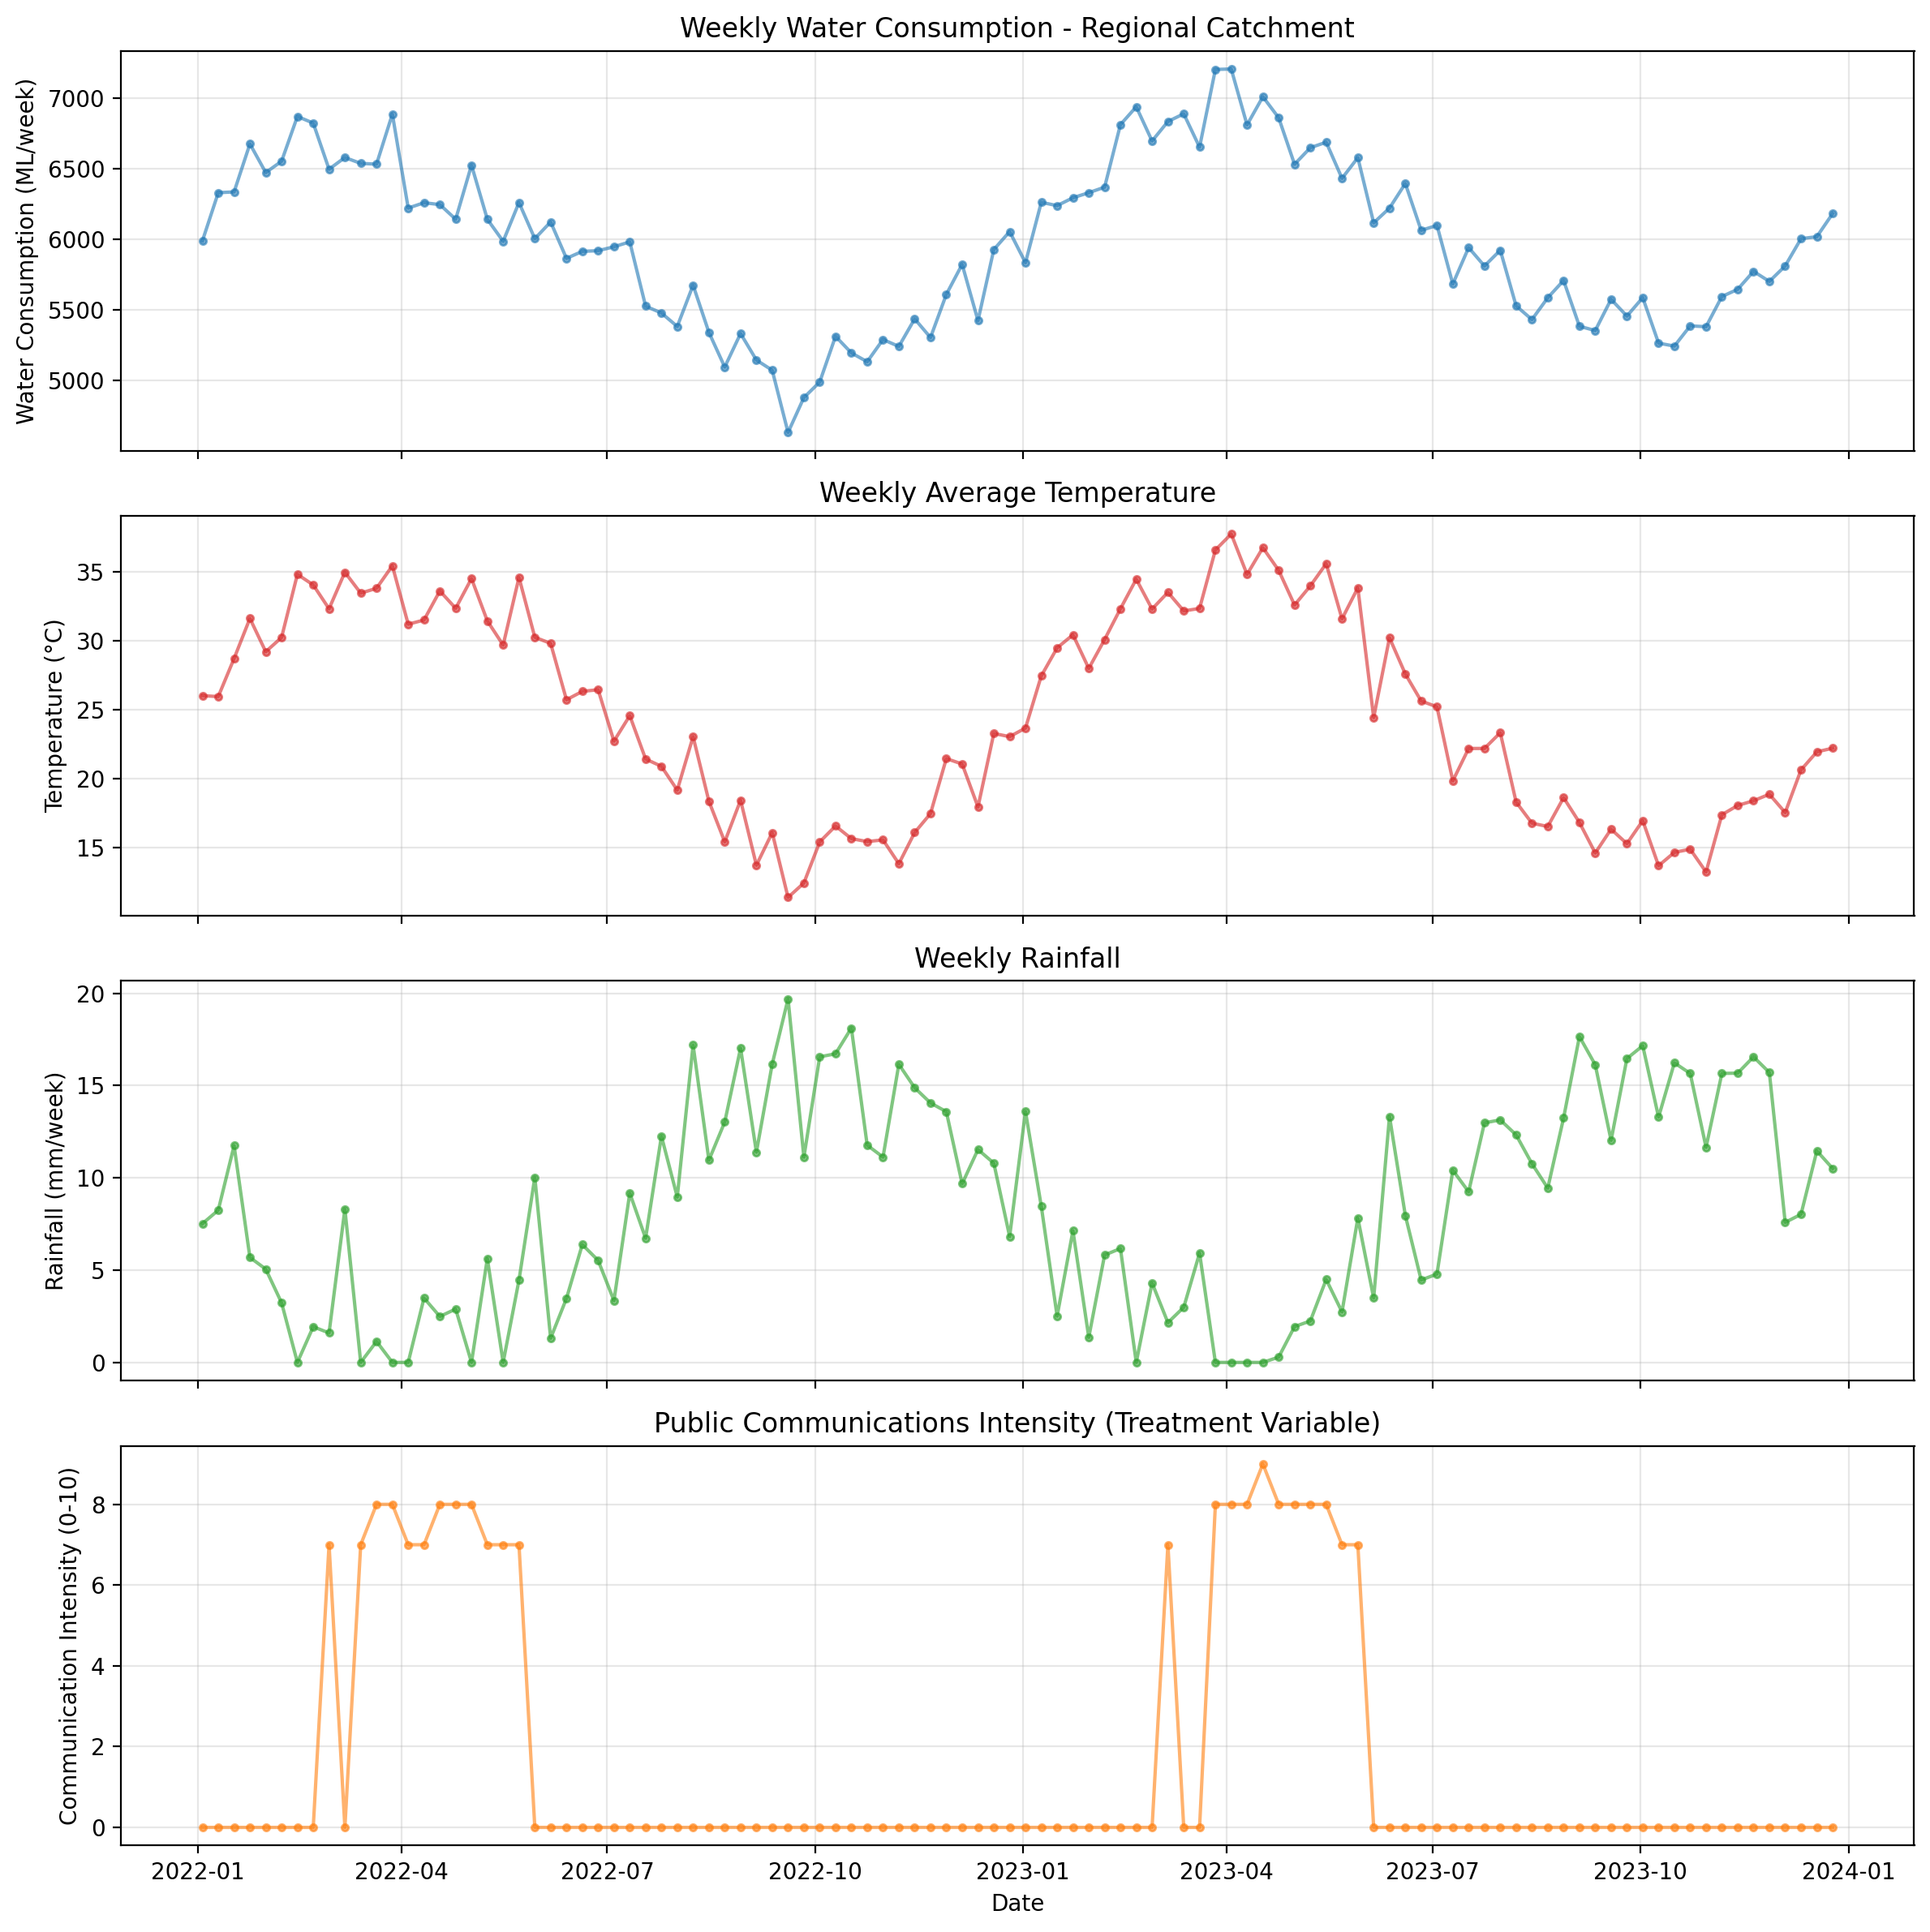


Key patterns in the data:
- Very dry climate: 0-16mm/week rainfall, with extended zero-rainfall periods in summer
- Communication intensity is zero most of the time (no routine messaging)
- Communications only activate during sustained drought (6-week rainfall < 20mm)
- Policy responds to cumulative rainfall deficit, not just current week
- When drought conditions persist, communication intensity ramps up to 6-10 range


In [3]:
fig, axes = plt.subplots(4, 1, figsize=(12, 12), sharex=True)

# Water consumption
axes[0].plot(df.index, df["water_consumption"], "o-", alpha=0.6, markersize=3)
axes[0].set_ylabel("Water Consumption (ML/week)")
axes[0].set_title("Weekly Water Consumption - Regional Catchment")
axes[0].grid(True, alpha=0.3)

# Temperature
axes[1].plot(df.index, df["temperature"], "o-", alpha=0.6, markersize=3, color="C3")
axes[1].set_ylabel("Temperature (°C)")
axes[1].set_title("Weekly Average Temperature")
axes[1].grid(True, alpha=0.3)

# Rainfall
axes[2].plot(df.index, df["rainfall"], "o-", alpha=0.6, markersize=3, color="C2")
axes[2].set_ylabel("Rainfall (mm/week)")
axes[2].set_title("Weekly Rainfall")
axes[2].grid(True, alpha=0.3)

# Communication intensity
axes[3].plot(df.index, df["comm_intensity"], "o-", alpha=0.6, markersize=3, color="C1")
axes[3].set_ylabel("Communication Intensity (0-10)")
axes[3].set_title("Public Communications Intensity (Treatment Variable)")
axes[3].set_xlabel("Date")
axes[3].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Show correlation between variables
print("\nKey patterns in the data:")
print(
    "- Very dry climate: 0-16mm/week rainfall, with extended zero-rainfall periods in summer"
)
print("- Communication intensity is zero most of the time (no routine messaging)")
print(
    "- Communications only activate during sustained drought (6-week rainfall < 20mm)"
)
print("- Policy responds to cumulative rainfall deficit, not just current week")
print(
    "- When drought conditions persist, communication intensity ramps up to 6-10 range"
)

## 3. Estimate Transform Parameters from Data

Transform parameters (saturation and adstock) are estimated from the data to find the best fit. CausalPy provides two methods for parameter estimation:
- **Grid search**: Exhaustive search over discrete parameter values (slower but guaranteed to find best combination)
- **Continuous optimization**: Uses scipy.optimize for faster search (may find local optima)

Let's estimate the transform parameters using grid search. We'll use a coarse grid for speed in this demo, but you can make it finer for production use.


In [4]:
# Estimate transform parameters using grid search
result_estimated = cp.TransferFunctionITS.with_estimated_transforms(
    data=df,
    y_column="water_consumption",
    treatment_name="comm_intensity",
    base_formula="1 + t + temperature + rainfall",
    estimation_method="grid",
    saturation_type="hill",
    saturation_grid={
        "slope": [1.0, 1.5, 2.0, 2.5, 3.0],  # Search around true value (2.0)
        "kappa": [3, 4, 5, 6, 7],  # Search around true value (5)
    },
    adstock_grid={
        "half_life": [2, 3, 4, 5, 6],  # Search around true value (4.0)
        "l_max": [12],  # Fixed
        "normalize": [True],  # Fixed
    },
)

print("Parameter estimation complete!")
print(f"Best RMSE: {result_estimated.transform_estimation_results['best_score']:.2f}")
print(f"Model R-squared: {result_estimated.score:.4f}")
print("\nEstimated parameters:")
print(result_estimated.transform_estimation_results["best_params"])

Parameter estimation complete!
Best RMSE: 110.95
Model R-squared: 0.9626

Estimated parameters:
{'slope': 3.0, 'kappa': 3, 'half_life': 4, 'l_max': 12, 'normalize': True}


## 4. Visualize Estimated vs True Transform Parameters

Since we know the true parameters used to generate the data, we can compare the estimated transforms to the true transforms. This helps us assess **parameter recovery** - how well the estimation procedure identifies the true data-generating process.

We'll visualize:
1. **Saturation curves**: How raw communication intensity gets transformed by saturation
2. **Adstock weights**: How effects carry over across weeks


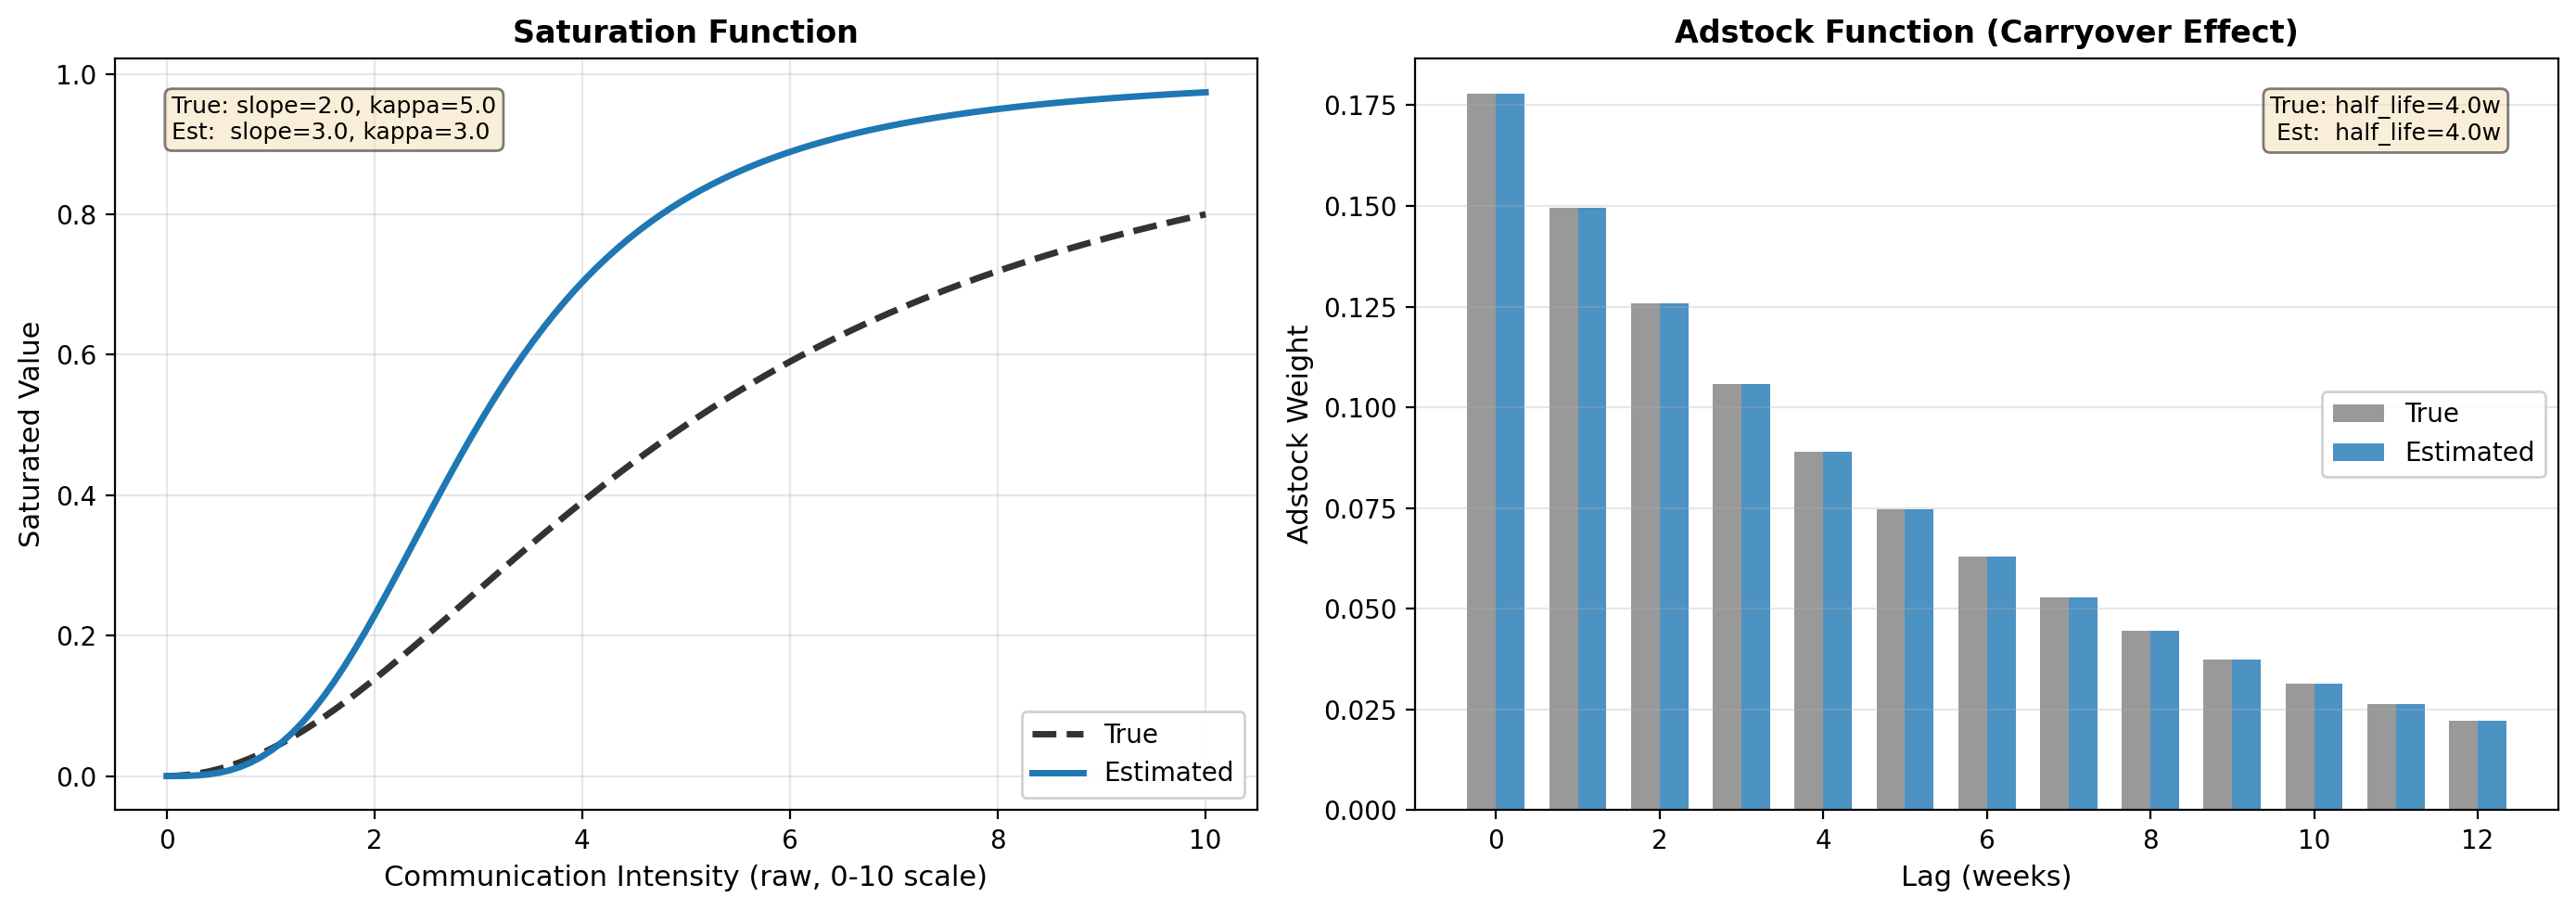


Parameter Recovery Assessment:
Saturation - slope error: 1.00
Saturation - kappa error: 2.00
Adstock - half_life error: 0.00 weeks


In [5]:
# Create true transform objects (parameters used for data generation)
true_saturation = cp.HillSaturation(slope=2.0, kappa=5)
true_adstock = cp.GeometricAdstock(half_life=4.0, l_max=12, normalize=True)

# Get estimated transform objects from fitted model
est_saturation = result_estimated.treatments[0].saturation
est_adstock = result_estimated.treatments[0].adstock

# Create figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ============================================================================
# LEFT PLOT: Saturation curves
# ============================================================================
x_sat = np.linspace(0, 10, 100)  # Communication intensity range 0-10

y_true_sat = true_saturation.apply(x_sat)
y_est_sat = est_saturation.apply(x_sat)

axes[0].plot(x_sat, y_true_sat, "k--", linewidth=2.5, label="True", alpha=0.8)
axes[0].plot(x_sat, y_est_sat, "C0-", linewidth=2.5, label="Estimated")
axes[0].set_xlabel("Communication Intensity (raw, 0-10 scale)", fontsize=11)
axes[0].set_ylabel("Saturated Value", fontsize=11)
axes[0].set_title("Saturation Function", fontsize=12, fontweight="bold")
axes[0].legend(fontsize=10, framealpha=0.9)
axes[0].grid(True, alpha=0.3)

# Add parameter text
true_params = true_saturation.get_params()
est_params = est_saturation.get_params()
axes[0].text(
    0.05,
    0.95,
    f"True: slope={true_params['slope']:.1f}, kappa={true_params['kappa']:.1f}\n"
    f"Est:  slope={est_params['slope']:.1f}, kappa={est_params['kappa']:.1f}",
    transform=axes[0].transAxes,
    fontsize=9,
    verticalalignment="top",
    bbox=dict(boxstyle="round", facecolor="wheat", alpha=0.5),
)

# ============================================================================
# RIGHT PLOT: Adstock weights
# ============================================================================
lags = np.arange(13)  # 0 to l_max

# Compute adstock weights manually
true_alpha = true_adstock.get_params()["alpha"]
true_weights = true_alpha**lags
true_weights = true_weights / true_weights.sum()  # normalize

est_alpha = est_adstock.get_params()["alpha"]
est_weights = est_alpha**lags
est_weights = est_weights / est_weights.sum()  # normalize

width = 0.35
axes[1].bar(
    lags - width / 2, true_weights, width, alpha=0.8, label="True", color="gray"
)
axes[1].bar(
    lags + width / 2, est_weights, width, alpha=0.8, label="Estimated", color="C0"
)
axes[1].set_xlabel("Lag (weeks)", fontsize=11)
axes[1].set_ylabel("Adstock Weight", fontsize=11)
axes[1].set_title("Adstock Function (Carryover Effect)", fontsize=12, fontweight="bold")
axes[1].legend(fontsize=10, framealpha=0.9)
axes[1].grid(True, alpha=0.3, axis="y")

# Add parameter text
true_adstock_params = true_adstock.get_params()
est_adstock_params = est_adstock.get_params()
axes[1].text(
    0.95,
    0.95,
    f"True: half_life={true_adstock_params['half_life']:.1f}w\n"
    f"Est:  half_life={est_adstock_params['half_life']:.1f}w",
    transform=axes[1].transAxes,
    fontsize=9,
    verticalalignment="top",
    horizontalalignment="right",
    bbox=dict(boxstyle="round", facecolor="wheat", alpha=0.5),
)

plt.tight_layout()
plt.show()

print("\nParameter Recovery Assessment:")
print(
    f"Saturation - slope error: {abs(est_params['slope'] - true_params['slope']):.2f}"
)
print(
    f"Saturation - kappa error: {abs(est_params['kappa'] - true_params['kappa']):.2f}"
)
print(
    f"Adstock - half_life error: {abs(est_adstock_params['half_life'] - true_adstock_params['half_life']):.2f} weeks"
)

**Interpretation:**

- **Saturation curve** (left): Shows how raw communication intensity (0-10) gets transformed by diminishing returns. The curve flattens at higher intensities, meaning the 10th message has much less impact than the 1st.

- **Adstock weights** (right): Shows how a communication "impulse" at week 0 affects water consumption over the following weeks. With half-life ~4 weeks, about 50% of the effect persists after 4 weeks. The bars show the relative contribution of each lag.

- **Parameter recovery**: In this simulated example with known ground truth, we can assess how well the estimation recovered the true parameters. Good recovery suggests the model specification is appropriate and the data is informative.

In real applications (without ground truth), you would:
- Use domain knowledge to set reasonable parameter grids/bounds
- Compare estimated curves to expert expectations
- Check sensitivity of results to different parameter ranges
- Consider alternative functional forms (logistic vs Hill saturation, etc.)


## 5. Model Methods and Diagnostics

Now that we have a fitted model with estimated transforms, let's explore the available methods for analysis and diagnostics.

### 5.1 Model Summary

View the fitted model coefficients and their **HAC standard errors** (robust to autocorrelation and heteroskedasticity):


In [6]:
# Display model summary
result_estimated.summary(round_to=2)

Transfer Function Interrupted Time Series Results
Outcome variable: water_consumption
Number of observations: 104
R-squared: 0.96
Error model: HAC
  HAC max lags: 4 (robust SEs accounting for 4 periods of autocorrelation)
--------------------------------------------------------------------------------
Baseline coefficients:
  Intercept           :       3990 (SE: 69)
  t                   :        4.3 (SE: 0.62)
  temperature         :         81 (SE: 3.1)
  rainfall            :        -16 (SE: 2.9)
--------------------------------------------------------------------------------
Treatment coefficients:
  comm_intensity      :       -460 (SE: 80)


### 5.2 Model Fit Visualization

Plot observed vs fitted values and residuals:


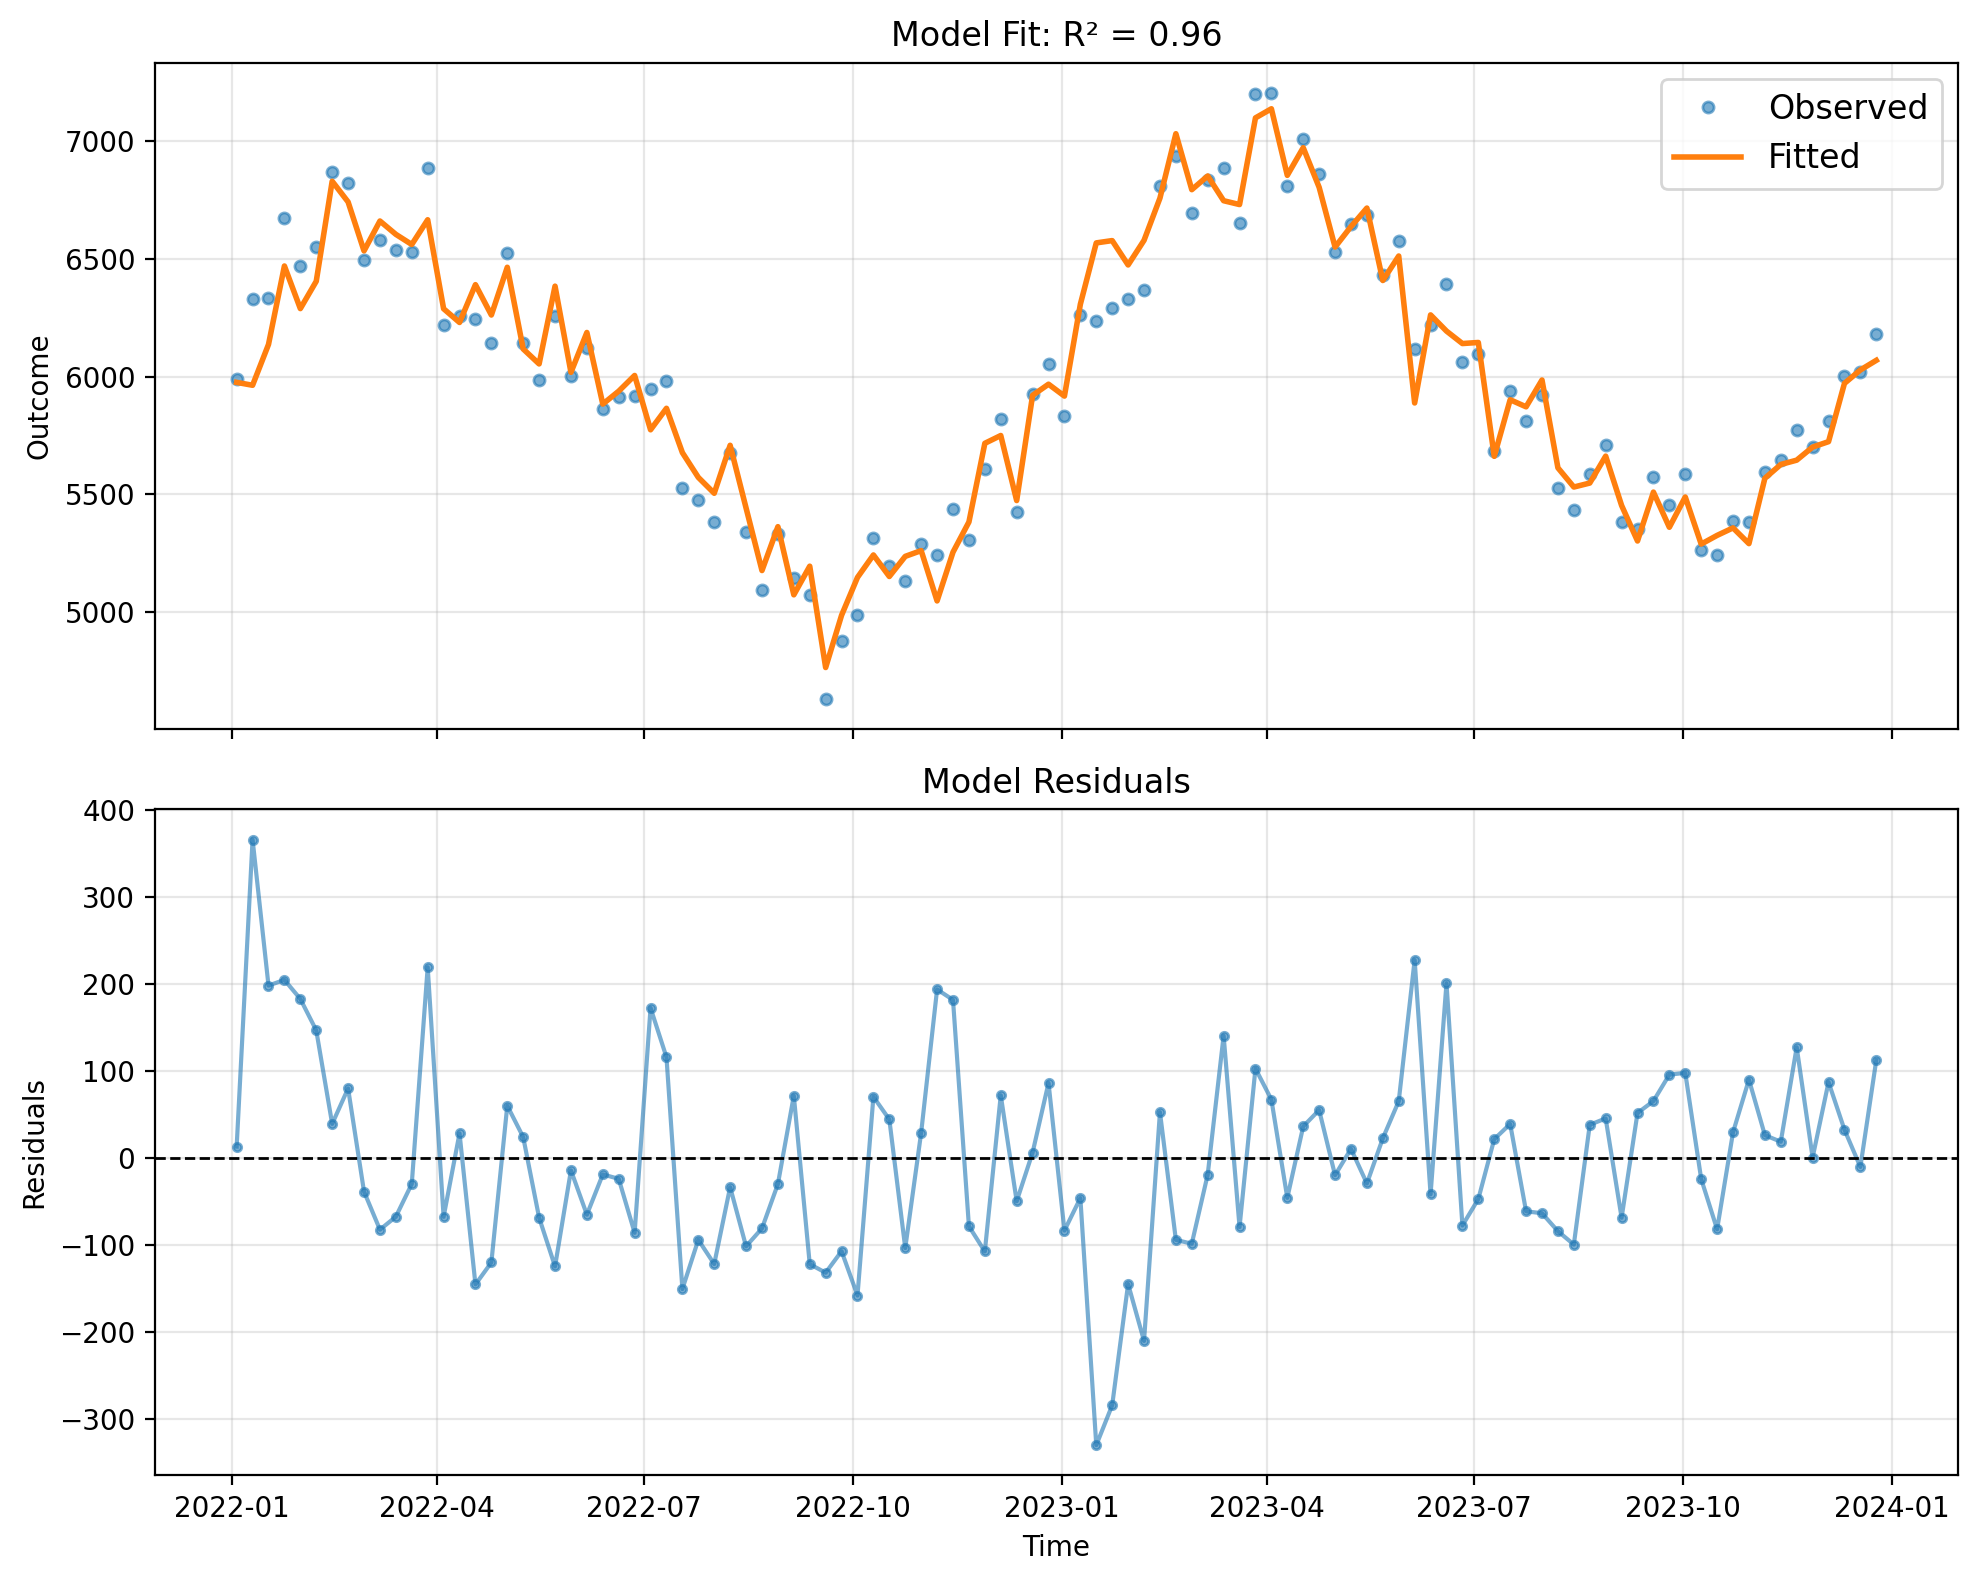

In [7]:
# Plot model fit
fig, ax = result_estimated.plot()
plt.show()

### 5.3 Residual Diagnostics

Check for autocorrelation in residuals using ACF/PACF plots and Ljung-Box test. 

**Important:** Finding autocorrelation here is **not a model failure** — it's expected! Even well-specified time series models have autocorrelated residuals due to unmodeled temporal factors. This is precisely why we use HAC standard errors (see next section).


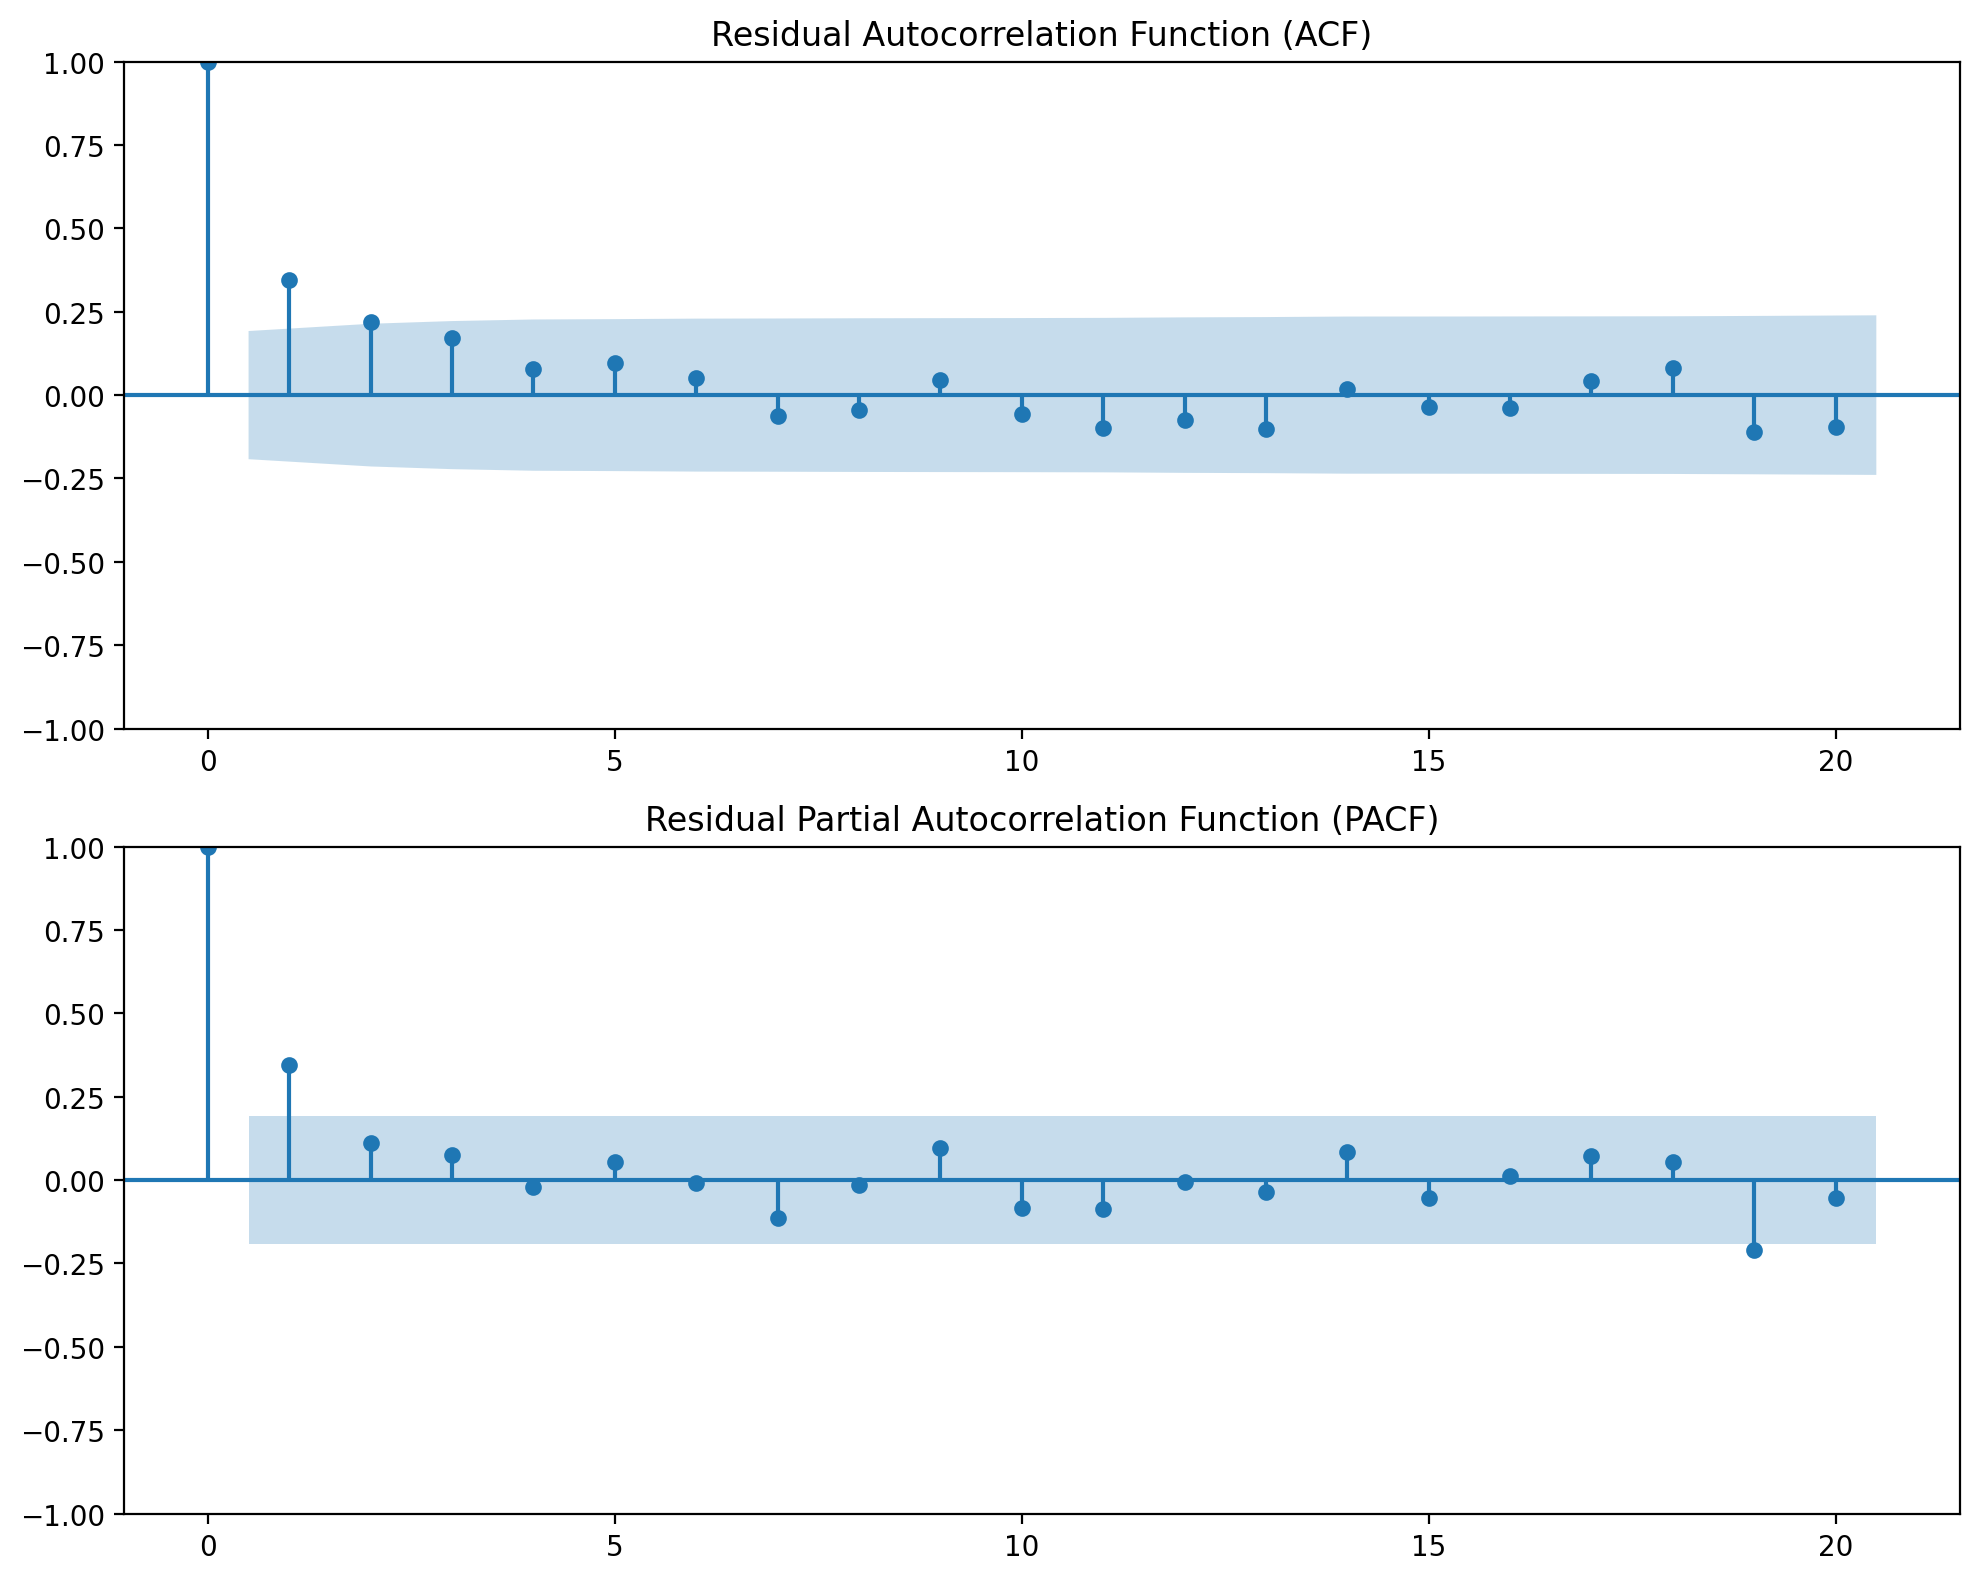


Ljung-Box Test for Residual Autocorrelation
H0: Residuals are independently distributed (no autocorrelation)
If p-value < 0.05, reject H0 (autocorrelation present)
------------------------------------------------------------
Lag  1: LB statistic =   12.826, p-value = 0.0003 ***
Lag  5: LB statistic =   22.897, p-value = 0.0004 ***
Lag 10: LB statistic =   24.489, p-value = 0.0064 ***
Lag 20: LB statistic =   31.803, p-value = 0.0454 *
------------------------------------------------------------
⚠ Warning: Significant residual autocorrelation detected.
  - HAC standard errors (already used) account for this in coefficient inference.
  - Consider adding more baseline controls or adjusting transform parameters.
  - FUTURE: GLSAR or ARIMAX models can explicitly model AR structure.


In [8]:
# Display diagnostic plots and tests
result_estimated.diagnostics(lags=20)

### 5.4 Why HAC Standard Errors Matter

The diagnostics above show **significant residual autocorrelation** (Ljung-Box test p-values < 0.05). This is **expected and realistic** even with a well-specified model! 

Our model includes the right variables (temperature, rainfall, time trend) and the right transforms (saturation, adstock), yet residuals are still autocorrelated. Why? Because real data always has **unmodeled factors with temporal persistence**:

- 🌡️ **Unmeasured weather**: We control for temperature and rainfall, but not humidity, wind, or soil moisture
- 👥 **Social contagion**: Neighbors influence each other's conservation behavior beyond our policy
- 📊 **Measurement dynamics**: Water meter reading schedules create systematic patterns
- 🏛️ **Institutional effects**: Maintenance schedules, local events, seasonal employment

This residual autocorrelation means **naive OLS standard errors are wrong** (typically too small). Let's demonstrate the problem and solution:


In [9]:
# Compare naive OLS standard errors vs HAC standard errors
import statsmodels.api as sm

# Refit the model with NAIVE (non-robust) standard errors
ols_naive = sm.OLS(result_estimated.y, result_estimated.X_full).fit()

# Extract treatment coefficient and standard errors
# Treatment comes after baseline in the full parameter vector
n_baseline = len(result_estimated.baseline_labels)
treatment_idx = n_baseline  # First treatment parameter index
coef = result_estimated.theta_treatment[0]

# Get standard errors
se_naive = ols_naive.bse[treatment_idx]
se_hac = result_estimated.ols_result.bse[treatment_idx]

# Compute confidence intervals
ci_naive_lower = coef - 1.96 * se_naive
ci_naive_upper = coef + 1.96 * se_naive
ci_hac_lower = coef - 1.96 * se_hac
ci_hac_upper = coef + 1.96 * se_hac

print("=" * 70)
print("COMPARISON: Naive OLS vs HAC Standard Errors")
print("=" * 70)
print(f"Treatment coefficient: {coef:.2f}")
print()
print(f"Naive OLS Standard Error:  {se_naive:.2f}")
print(f"  → 95% CI: [{ci_naive_lower:.2f}, {ci_naive_upper:.2f}]")
print(f"  → CI Width: {ci_naive_upper - ci_naive_lower:.2f}")
print()
print(f"HAC Standard Error:        {se_hac:.2f}")
print(f"  → 95% CI: [{ci_hac_lower:.2f}, {ci_hac_upper:.2f}]")
print(f"  → CI Width: {ci_hac_upper - ci_hac_lower:.2f}")
print()
print(f"SE Inflation Factor: {se_hac / se_naive:.2f}x")
print(
    f"CI Width Increase:   {(ci_hac_upper - ci_hac_lower) / (ci_naive_upper - ci_naive_lower):.2f}x"
)
print("=" * 70)
print()
print("📊 INTERPRETATION:")
print(
    f"• Naive SE is TOO SMALL by {(se_hac / se_naive - 1) * 100:.0f}% due to ignoring autocorrelation"
)
print(
    f"• HAC SE is {(se_hac / se_naive - 1) * 100:.0f}% larger, providing honest uncertainty"
)
print("• This means naive OLS gives OVERCONFIDENT inference (too-narrow CIs)")
print("• HAC corrects this, giving reliable inference despite residual correlation")
print()
print("✅ This demonstrates why TF-ITS uses HAC by default for time series data!")

COMPARISON: Naive OLS vs HAC Standard Errors
Treatment coefficient: -460.19

Naive OLS Standard Error:  47.57
  → 95% CI: [-553.42, -366.96]
  → CI Width: 186.47

HAC Standard Error:        79.60
  → 95% CI: [-616.20, -304.18]
  → CI Width: 312.02

SE Inflation Factor: 1.67x
CI Width Increase:   1.67x

📊 INTERPRETATION:
• Naive SE is TOO SMALL by 67% due to ignoring autocorrelation
• HAC SE is 67% larger, providing honest uncertainty
• This means naive OLS gives OVERCONFIDENT inference (too-narrow CIs)
• HAC corrects this, giving reliable inference despite residual correlation

✅ This demonstrates why TF-ITS uses HAC by default for time series data!


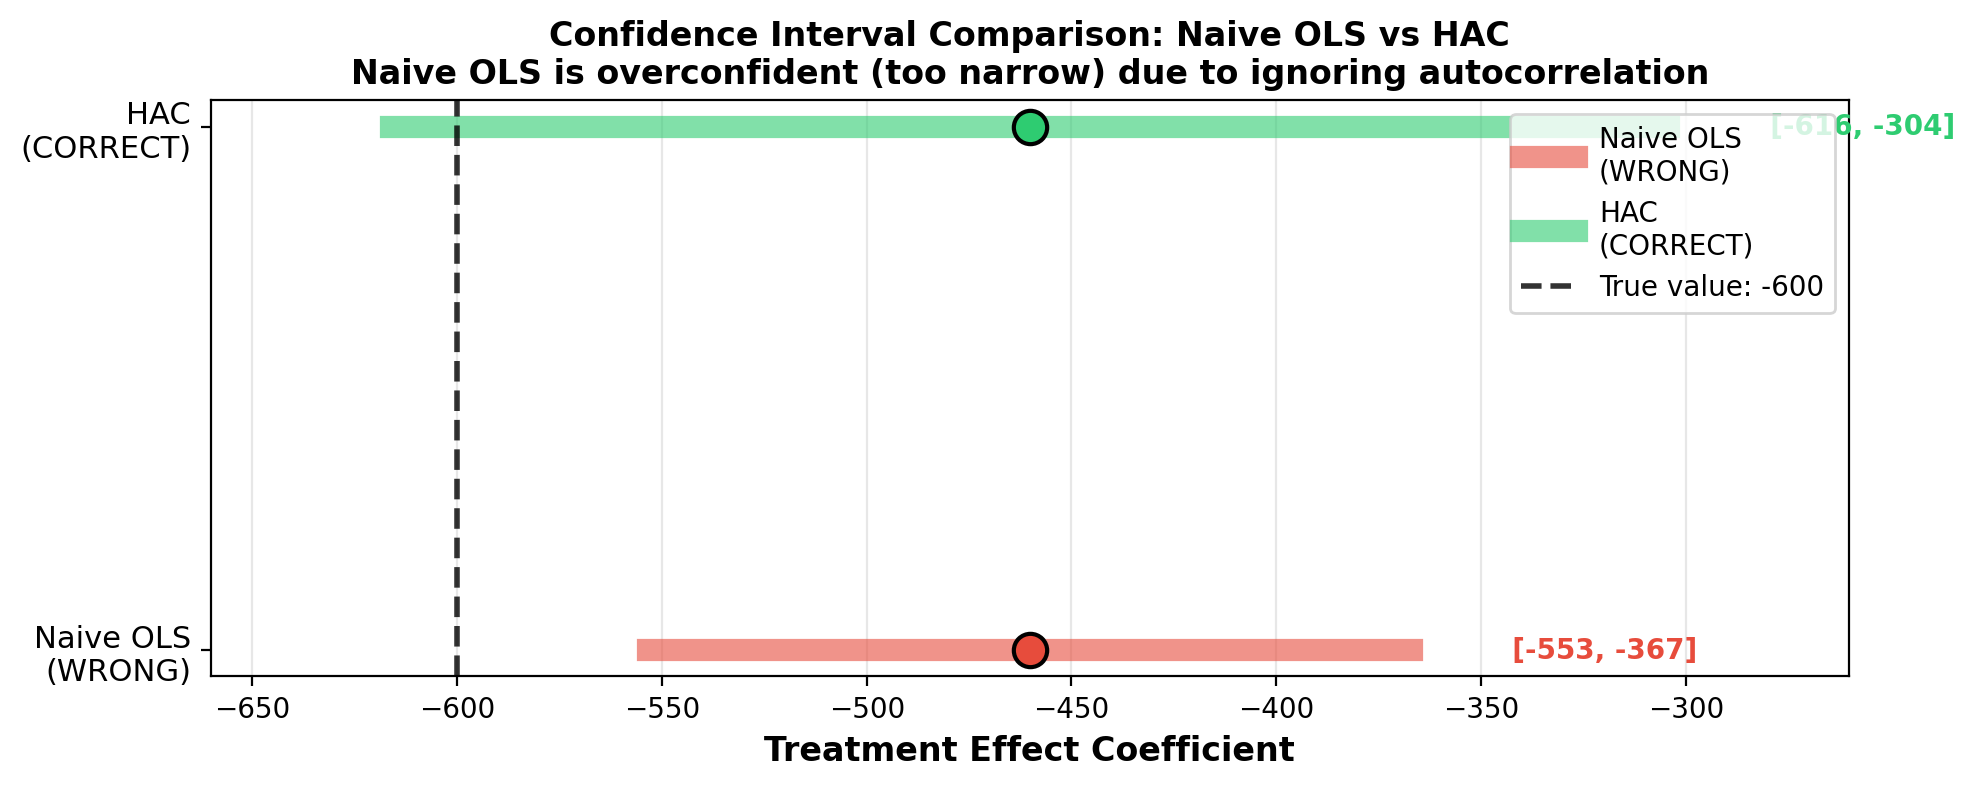


🎯 KEY TAKEAWAY:
The naive OLS confidence interval is dangerously narrow. If we relied on it,
we'd be overconfident about our treatment effect estimate. HAC provides the
correct, wider interval that honestly reflects uncertainty in the presence of
autocorrelated residuals. This is essential for valid inference in time series!


In [10]:
# Visualize the difference in confidence intervals
fig, ax = plt.subplots(figsize=(10, 4))

# Plot point estimate and confidence intervals
y_pos = [0, 1]
labels = ["Naive OLS\n(WRONG)", "HAC\n(CORRECT)"]
cis = [
    (ci_naive_lower, ci_naive_upper),
    (ci_hac_lower, ci_hac_upper),
]
colors = ["#e74c3c", "#2ecc71"]  # Red for naive, green for HAC

for i, (label, ci, color) in enumerate(zip(labels, cis, colors)):
    # Plot confidence interval as a horizontal line
    ax.plot(
        [ci[0], ci[1]],
        [y_pos[i], y_pos[i]],
        color=color,
        linewidth=8,
        alpha=0.6,
        label=f"{label}",
    )
    # Plot point estimate as a dot
    ax.plot(
        coef,
        y_pos[i],
        "o",
        color=color,
        markersize=12,
        markeredgecolor="black",
        markeredgewidth=1.5,
        zorder=10,
    )
    # Add CI text
    ax.text(
        ci[1] + 20,
        y_pos[i],
        f"  [{ci[0]:.0f}, {ci[1]:.0f}]",
        va="center",
        fontsize=10,
        color=color,
        fontweight="bold",
    )

# Add true value line (we know it from simulation)
ax.axvline(
    theta_true,
    color="black",
    linestyle="--",
    linewidth=2,
    alpha=0.8,
    label=f"True value: {theta_true:.0f}",
    zorder=5,
)

ax.set_yticks(y_pos)
ax.set_yticklabels(labels, fontsize=11)
ax.set_xlabel("Treatment Effect Coefficient", fontsize=12, fontweight="bold")
ax.set_title(
    "Confidence Interval Comparison: Naive OLS vs HAC\n"
    "Naive OLS is overconfident (too narrow) due to ignoring autocorrelation",
    fontsize=12,
    fontweight="bold",
)
ax.legend(loc="upper right", fontsize=10)
ax.grid(True, alpha=0.3, axis="x")
ax.set_xlim(coef - 200, coef + 200)

plt.tight_layout()
plt.show()

print("\n🎯 KEY TAKEAWAY:")
print("The naive OLS confidence interval is dangerously narrow. If we relied on it,")
print("we'd be overconfident about our treatment effect estimate. HAC provides the")
print("correct, wider interval that honestly reflects uncertainty in the presence of")
print("autocorrelated residuals. This is essential for valid inference in time series!")

### 5.5 Impulse Response Function

Visualize how communication effects persist over time through the adstock transformation:


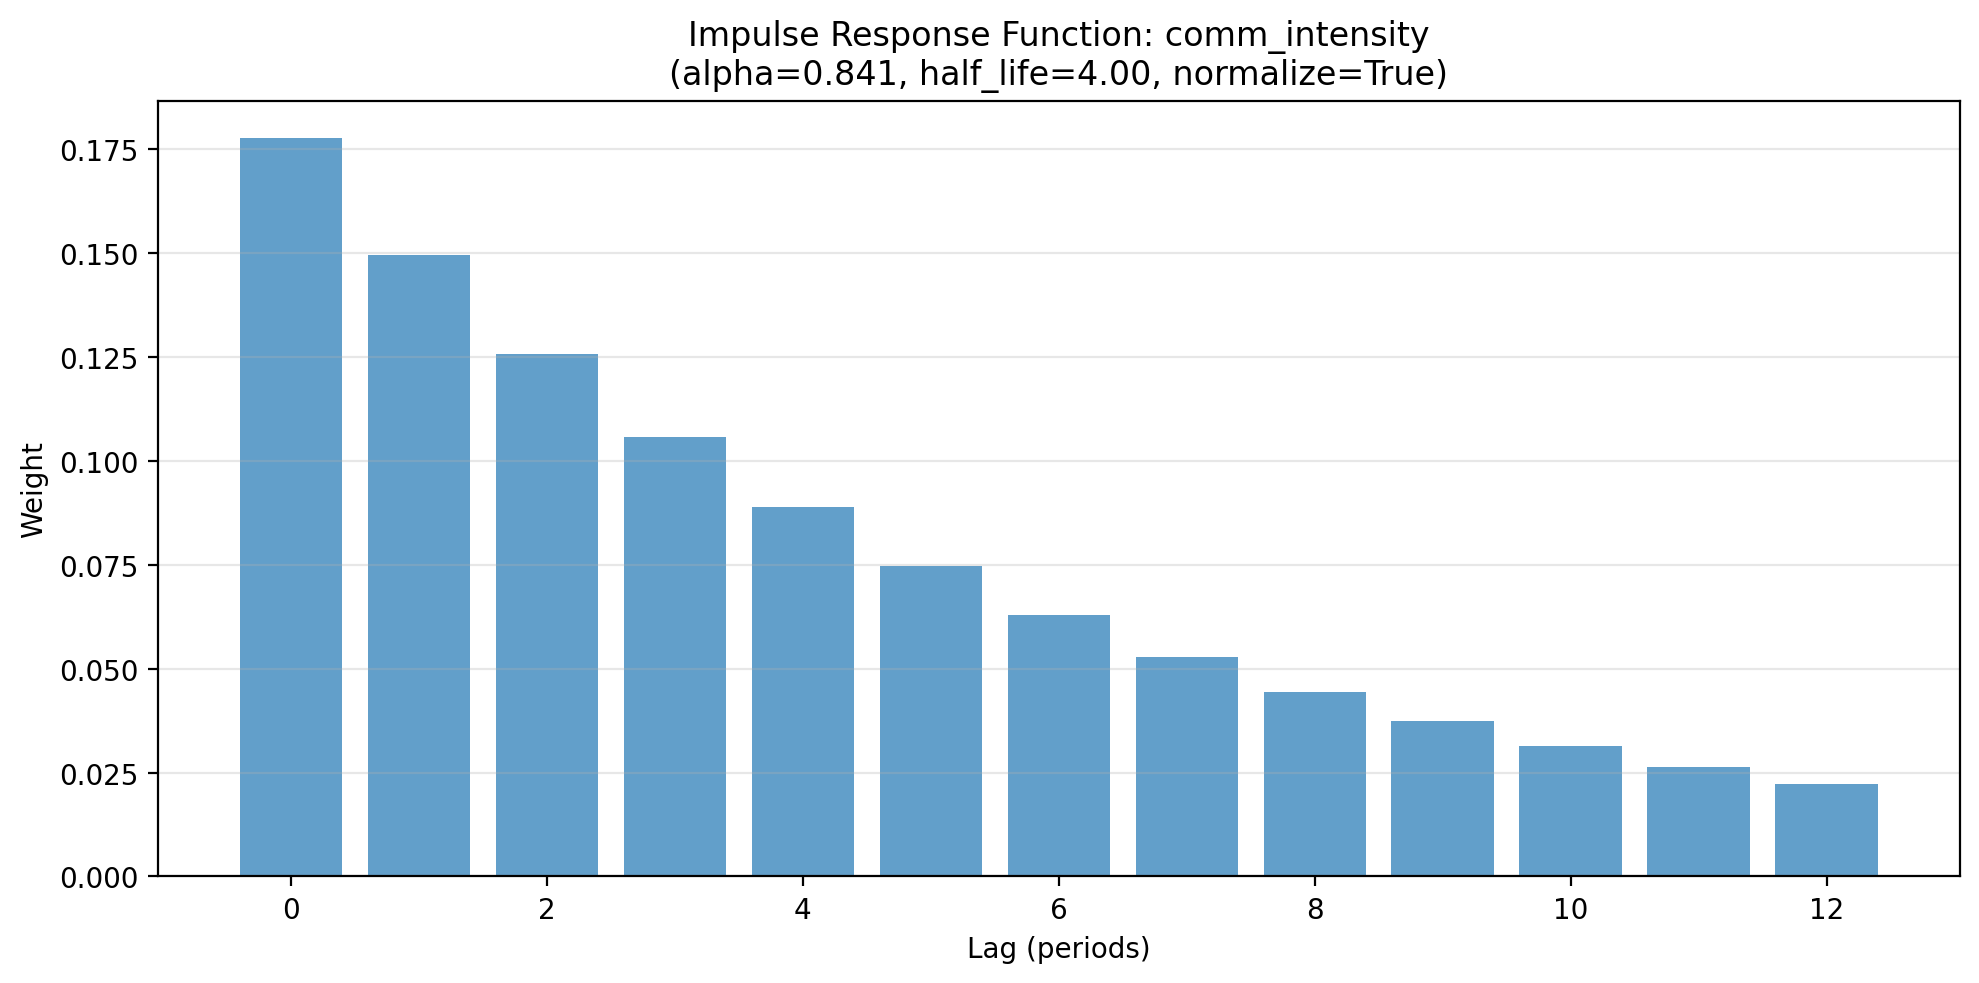

In [11]:
# Plot impulse response function
fig = result_estimated.plot_irf("comm_intensity", max_lag=12)
plt.show()

### 5.6 Counterfactual Effect Estimation

Estimate the effect of the communications policy by comparing observed outcomes to a counterfactual where communications were never implemented:


In [12]:
# Estimate effect of policy over entire 2-year period
# Counterfactual: set all communications to zero
effect_result = result_estimated.effect(
    window=(df.index[0], df.index[-1]),
    channels=["comm_intensity"],
    scale=0.0,  # Zero out all communications (no policy counterfactual)
)

print(
    f"Total water saved by communications policy: {-effect_result['total_effect']:.0f} ML"
)
print(f"Average weekly savings: {-effect_result['mean_effect']:.0f} ML/week")
print(
    f"Percentage reduction: {-100 * effect_result['mean_effect'] / df['water_consumption'].mean():.1f}%"
)

Total water saved by communications policy: 9955 ML
Average weekly savings: 96 ML/week
Percentage reduction: 1.6%


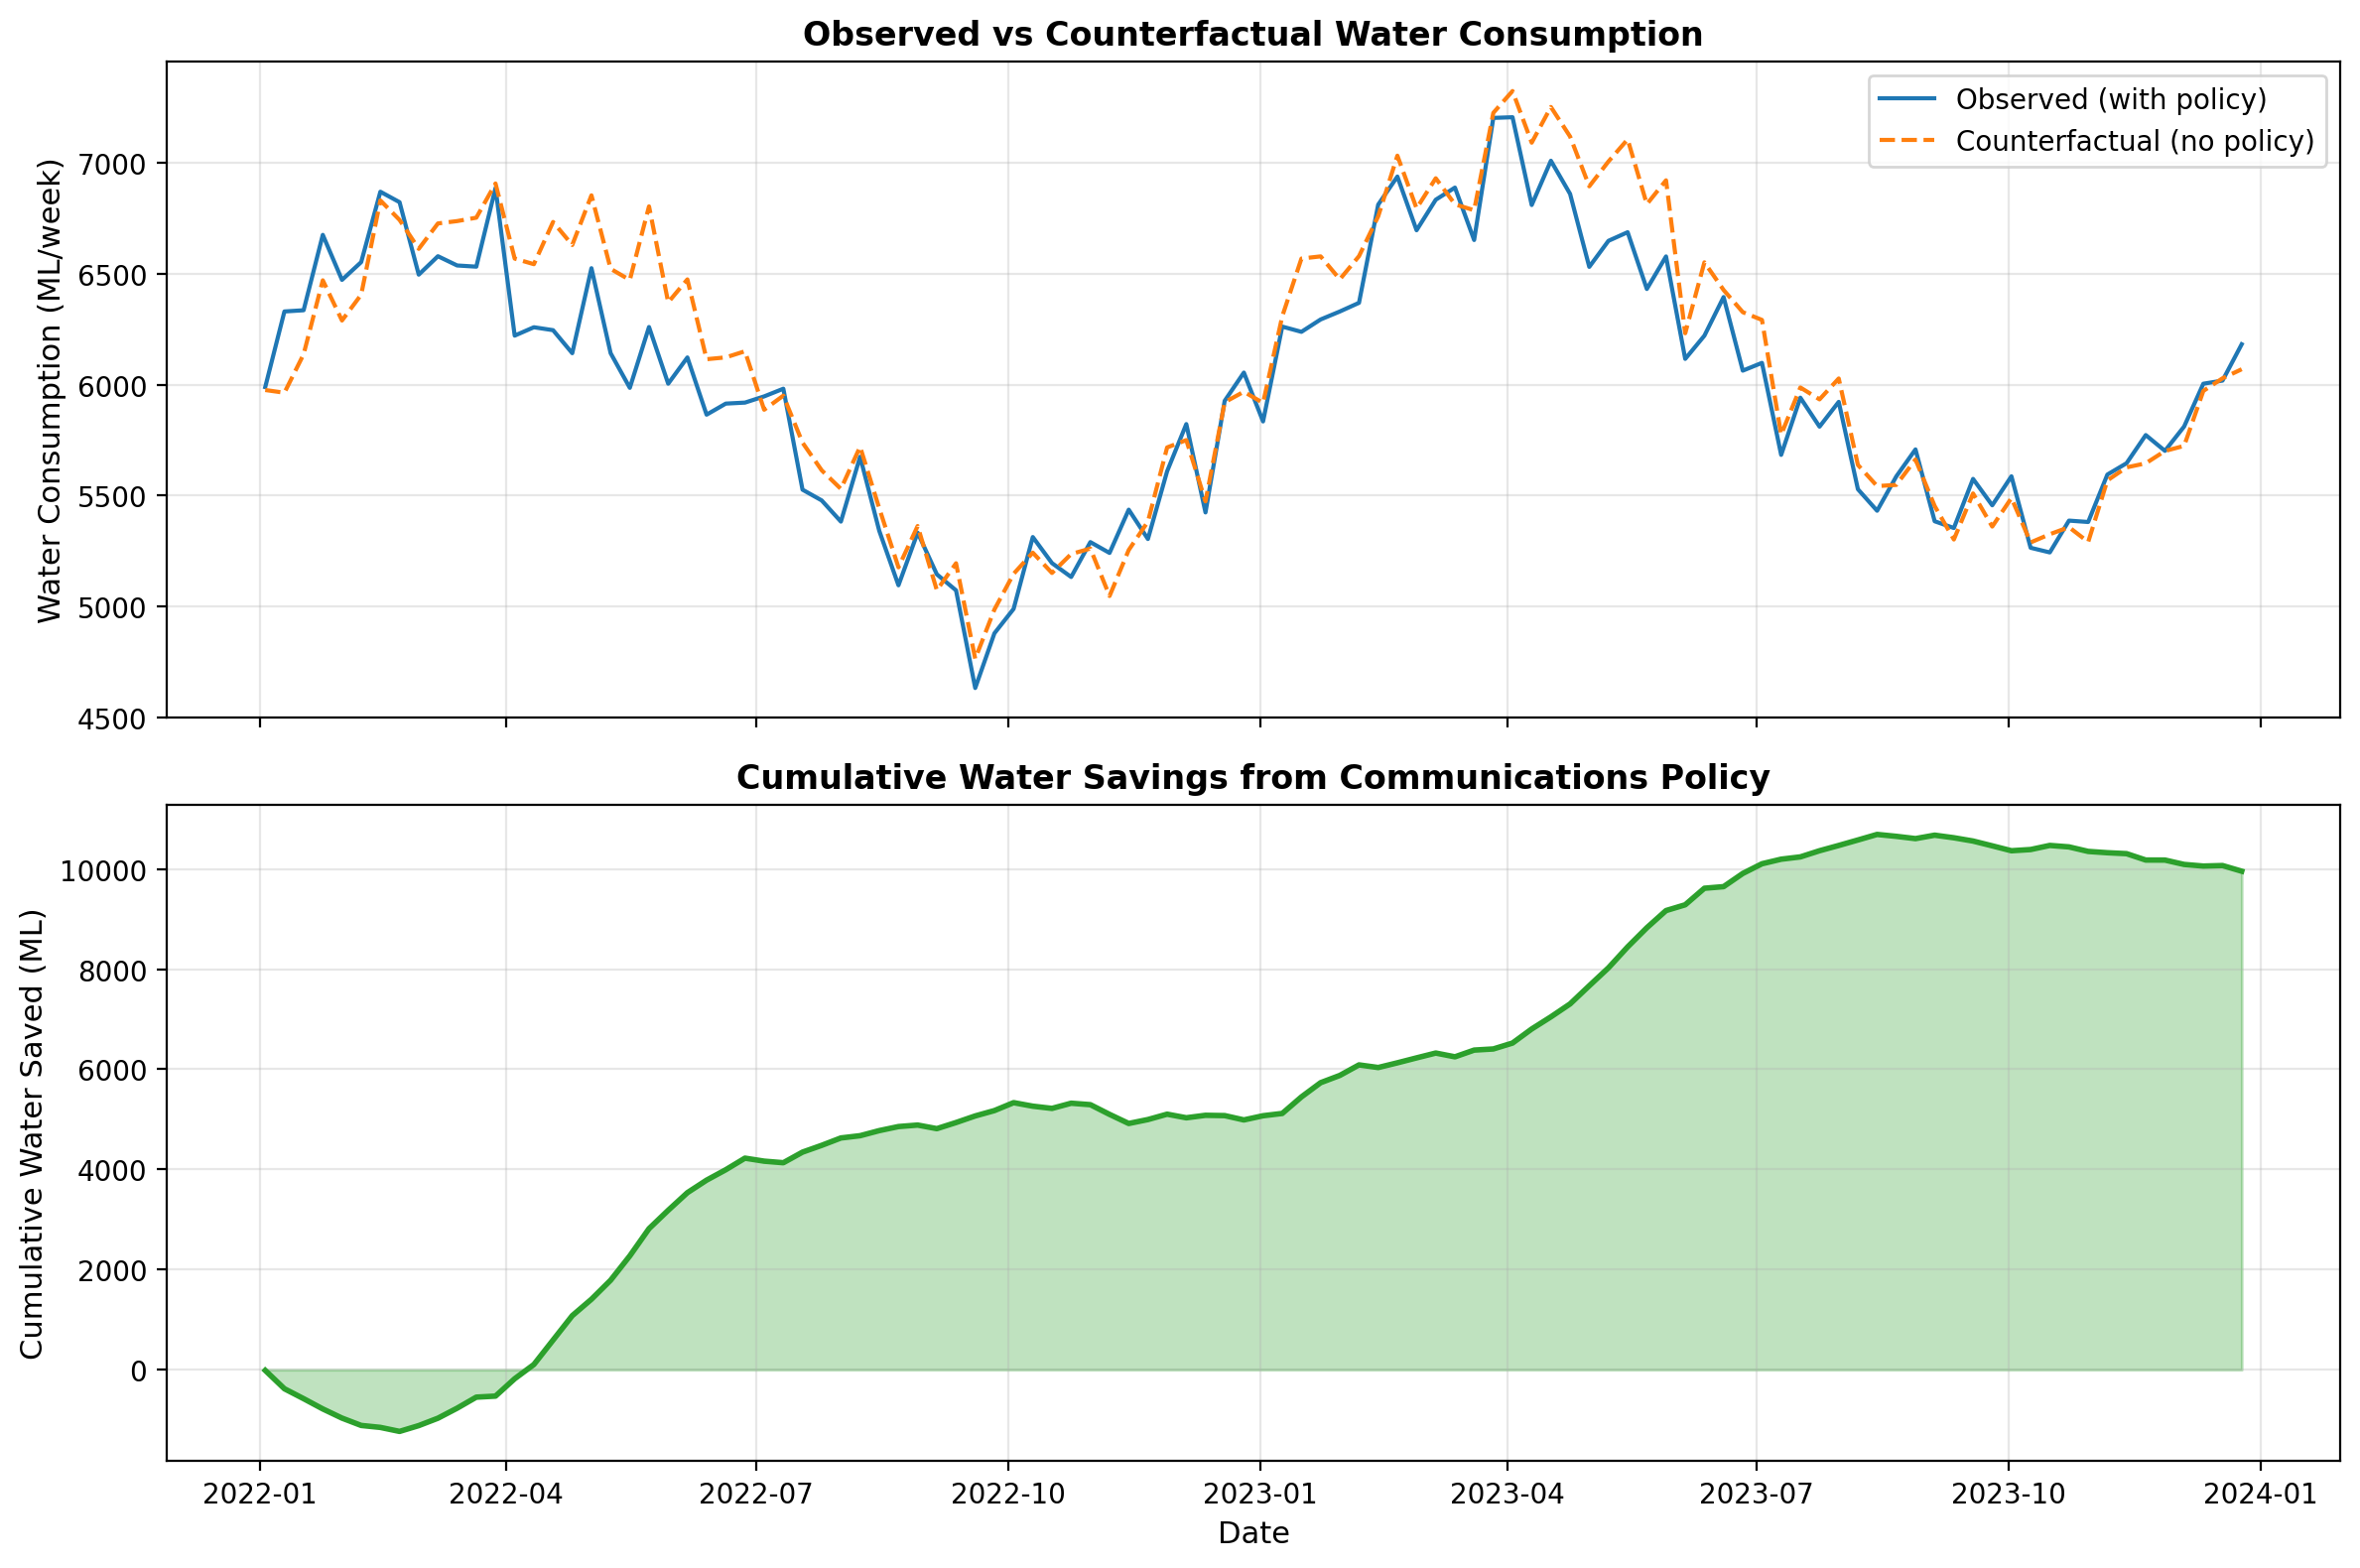


The communications policy saved approximately 9955 ML of water over the 2-year period, representing a 1.6% reduction in consumption.


In [13]:
# Visualize the counterfactual analysis
effect_df = effect_result["effect_df"]

fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# Top panel: Observed vs Counterfactual
axes[0].plot(
    effect_df.index,
    effect_df["observed"],
    label="Observed (with policy)",
    linewidth=1.5,
)
axes[0].plot(
    effect_df.index,
    effect_df["counterfactual"],
    label="Counterfactual (no policy)",
    linewidth=1.5,
    linestyle="--",
)
axes[0].set_ylabel("Water Consumption (ML/week)", fontsize=11)
axes[0].set_title(
    "Observed vs Counterfactual Water Consumption", fontsize=12, fontweight="bold"
)
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# Bottom panel: Cumulative effect (water saved)
axes[1].plot(effect_df.index, -effect_df["effect_cumulative"], linewidth=2, color="C2")
axes[1].fill_between(
    effect_df.index, 0, -effect_df["effect_cumulative"], alpha=0.3, color="C2"
)
axes[1].set_ylabel("Cumulative Water Saved (ML)", fontsize=11)
axes[1].set_xlabel("Date", fontsize=11)
axes[1].set_title(
    "Cumulative Water Savings from Communications Policy",
    fontsize=12,
    fontweight="bold",
)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(
    f"\nThe communications policy saved approximately {-effect_result['total_effect']:.0f} ML of water "
    f"over the 2-year period, representing a {-100 * effect_result['mean_effect'] / df['water_consumption'].mean():.1f}% "
    "reduction in consumption."
)

## 6. Alternative Error Model: ARIMAX

So far we've used **HAC (Newey-West) standard errors**, which provide robust inference without requiring us to specify the autocorrelation structure. This is the recommended default approach.

However, TF-ITS also supports **ARIMAX (ARIMA with eXogenous variables)** error models, following the classical Box & Tiao (1975) intervention analysis framework. ARIMAX explicitly models the ARIMA(p,d,q) structure of the residuals.

### When to Consider ARIMAX:

**Advantages:**
- **More efficient**: Smaller standard errors when the ARIMA structure is correctly specified
- **Classical approach**: Follows Box & Tiao's original intervention analysis methodology
- **Explicit error modeling**: Can characterize and forecast the residual dynamics

**Disadvantages:**
- **Requires specification**: Must choose p, d, q orders (typically via ACF/PACF plots)
- **Misspecification risk**: Wrong orders lead to biased or inefficient inference
- **Less robust**: Sensitive to outliers and structural breaks

**Recommendation**: Use HAC as default (robust, no specification). Consider ARIMAX when:
- You have strong evidence for a specific ARIMA structure (e.g., from ACF/PACF)
- Sample size is small and efficiency matters
- You want to follow classical time series methodology exactly


### 6.1 Fit Model with ARIMAX Errors

Since we generated the data with AR(1) errors (`rho_error = 0.5`), we know the true error structure is ARIMA(1,0,0). Let's fit the model with ARIMAX using this specification:


In [14]:
# Fit with ARIMAX error model
# We specify ARIMA(1,0,0) since we know the data has AR(1) errors
# In practice, you would use ACF/PACF plots to determine the appropriate orders
result_arimax = cp.TransferFunctionITS.with_estimated_transforms(
    data=df,
    y_column="water_consumption",
    treatment_name="comm_intensity",
    base_formula="1 + t + temperature + rainfall",
    estimation_method="grid",
    saturation_type="hill",
    saturation_grid={
        "slope": [1.0, 1.5, 2.0, 2.5, 3.0],
        "kappa": [3, 4, 5, 6, 7],
    },
    adstock_grid={
        "half_life": [2, 3, 4, 5, 6],
        "l_max": [12],
        "normalize": [True],
    },
    error_model="arimax",  # Use ARIMAX instead of HAC
    arima_order=(1, 0, 0),  # AR(1) errors: p=1, d=0, q=0
)

print("ARIMAX model fitted successfully!")
print(
    f"Best transform parameters: {result_arimax.transform_estimation_results['best_params']}"
)

ARIMAX model fitted successfully!
Best transform parameters: {'slope': 3.0, 'kappa': 3, 'half_life': 4, 'l_max': 12, 'normalize': True}


In [15]:
# View summary - note the ARIMA order is displayed
result_arimax.summary(round_to=2)

Transfer Function Interrupted Time Series Results
Outcome variable: water_consumption
Number of observations: 104
R-squared: 0.97
Error model: ARIMAX
  ARIMA order: (1, 0, 0)
    p=1: AR order, d=0: differencing, q=0: MA order
--------------------------------------------------------------------------------
Baseline coefficients:
  Intercept           :       4051 (SE: 100)
  t                   :        4.4 (SE: 0.65)
  temperature         :         79 (SE: 3)
  rainfall            :        -18 (SE: 3.4)
--------------------------------------------------------------------------------
Treatment coefficients:
  comm_intensity      :       -468 (SE: 69)


### 6.2 Comparison: HAC vs ARIMAX

Let's compare the two approaches side-by-side to understand their differences:


In [16]:
# Extract treatment coefficient and standard errors from both models
n_baseline = len(result_estimated.baseline_labels)
treatment_idx = n_baseline

# HAC model
coef_hac = result_estimated.theta_treatment[0]
se_hac = result_estimated.ols_result.bse[treatment_idx]
ci_hac_lower = coef_hac - 1.96 * se_hac
ci_hac_upper = coef_hac + 1.96 * se_hac

# ARIMAX model
coef_arimax = result_arimax.theta_treatment[0]
se_arimax = result_arimax.ols_result.bse[treatment_idx]
ci_arimax_lower = coef_arimax - 1.96 * se_arimax
ci_arimax_upper = coef_arimax + 1.96 * se_arimax

# Create comparison table
comparison_data = {
    "Method": ["HAC", "ARIMAX"],
    "Coefficient": [f"{coef_hac:.2f}", f"{coef_arimax:.2f}"],
    "Std Error": [f"{se_hac:.2f}", f"{se_arimax:.2f}"],
    "95% CI": [
        f"[{ci_hac_lower:.2f}, {ci_hac_upper:.2f}]",
        f"[{ci_arimax_lower:.2f}, {ci_arimax_upper:.2f}]",
    ],
    "CI Width": [
        f"{ci_hac_upper - ci_hac_lower:.2f}",
        f"{ci_arimax_upper - ci_arimax_lower:.2f}",
    ],
}

comparison_df = pd.DataFrame(comparison_data)

print("=" * 80)
print("COMPARISON: HAC vs ARIMAX")
print("=" * 80)
print(comparison_df.to_string(index=False))
print("=" * 80)
print()
print("KEY OBSERVATIONS:")
print(f"• Coefficients are similar: HAC={coef_hac:.2f}, ARIMAX={coef_arimax:.2f}")
print(f"• SE ratio (ARIMAX/HAC): {se_arimax / se_hac:.3f}")
if se_arimax < se_hac:
    print(
        f"• ARIMAX has {(1 - se_arimax / se_hac) * 100:.1f}% smaller SE (more efficient when correctly specified)"
    )
else:
    print(
        f"• HAC has {(1 - se_hac / se_arimax) * 100:.1f}% smaller SE (may indicate ARIMAX misspecification)"
    )
print("• Both models give similar inference about the treatment effect")

COMPARISON: HAC vs ARIMAX
Method Coefficient Std Error             95% CI CI Width
   HAC     -460.19     79.60 [-616.20, -304.18]   312.02
ARIMAX     -468.06     69.29 [-603.87, -332.25]   271.62

KEY OBSERVATIONS:
• Coefficients are similar: HAC=-460.19, ARIMAX=-468.06
• SE ratio (ARIMAX/HAC): 0.871
• ARIMAX has 12.9% smaller SE (more efficient when correctly specified)
• Both models give similar inference about the treatment effect


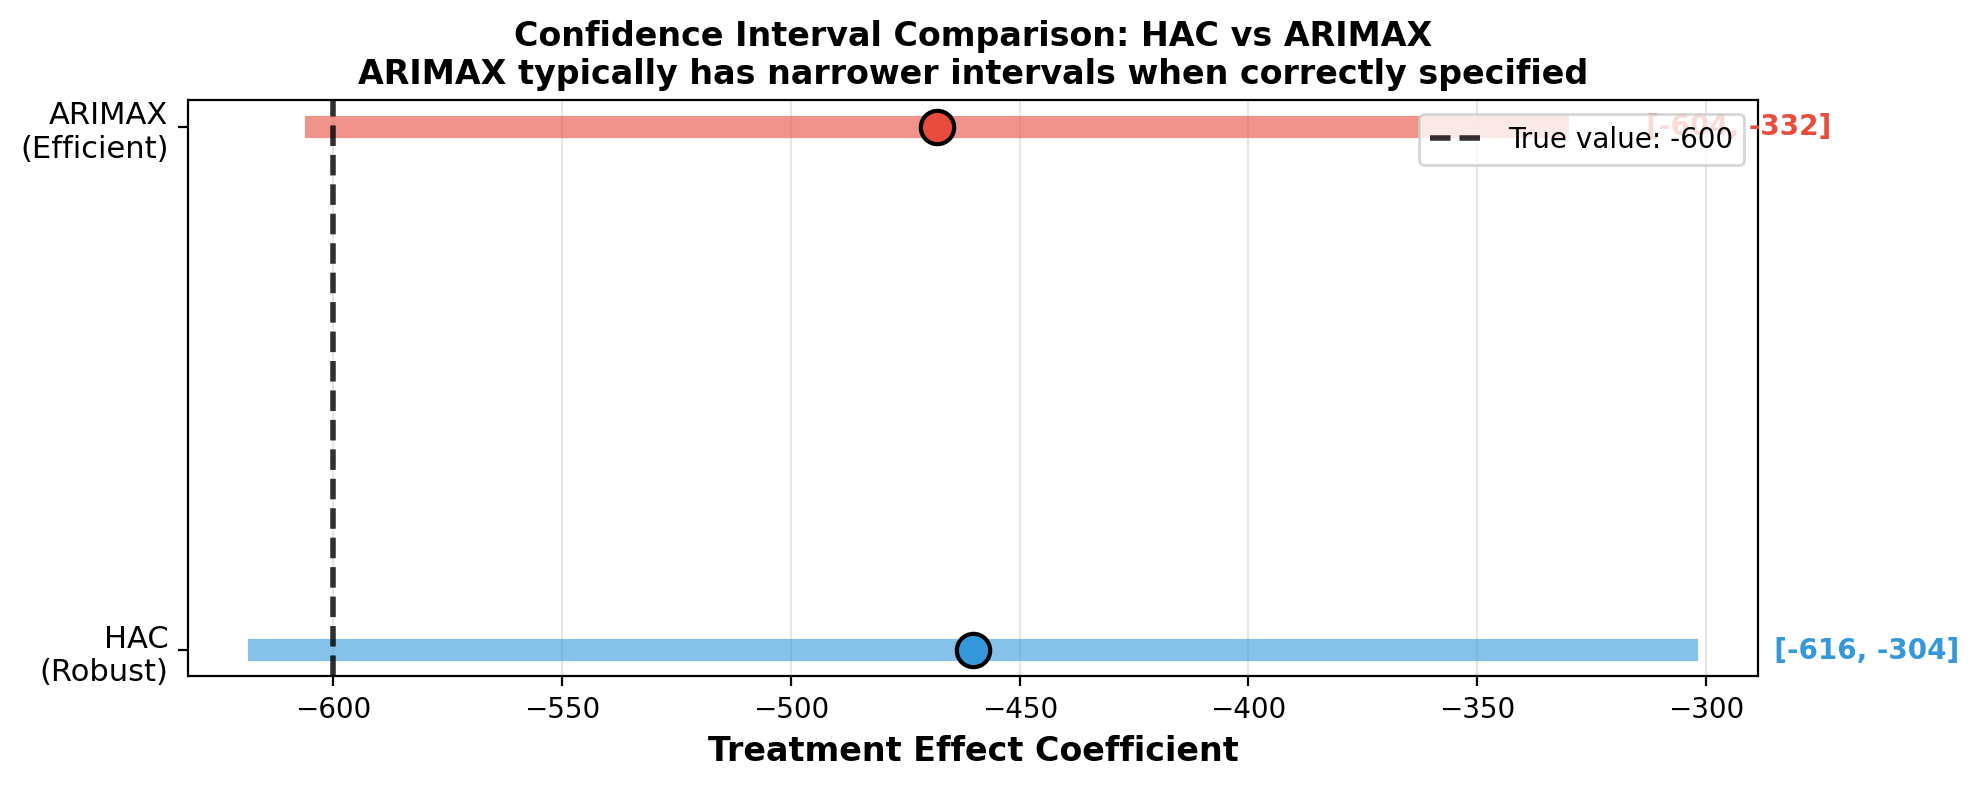


📊 INTERPRETATION:
Both methods capture the true treatment effect, but ARIMAX provides narrower
confidence intervals (more precise estimates) because it explicitly models the AR(1)
error structure. HAC is more conservative but doesn't require specification.


In [17]:
# Visualize confidence interval comparison
fig, ax = plt.subplots(figsize=(10, 4))

y_pos = [0, 1]
labels = ["HAC\n(Robust)", "ARIMAX\n(Efficient)"]
cis = [(ci_hac_lower, ci_hac_upper), (ci_arimax_lower, ci_arimax_upper)]
colors = ["#3498db", "#e74c3c"]  # Blue for HAC, Red for ARIMAX

for i, (label, ci, color) in enumerate(zip(labels, cis, colors)):
    # Plot confidence interval
    ax.plot([ci[0], ci[1]], [y_pos[i], y_pos[i]], color=color, linewidth=8, alpha=0.6)
    # Plot point estimate
    coef = coef_hac if i == 0 else coef_arimax
    ax.plot(
        coef,
        y_pos[i],
        "o",
        color=color,
        markersize=12,
        markeredgecolor="black",
        markeredgewidth=1.5,
        zorder=10,
    )
    # Add CI text
    ax.text(
        ci[1] + 15,
        y_pos[i],
        f"  [{ci[0]:.0f}, {ci[1]:.0f}]",
        va="center",
        fontsize=10,
        color=color,
        fontweight="bold",
    )

# Add true value line
ax.axvline(
    theta_true,
    color="black",
    linestyle="--",
    linewidth=2,
    alpha=0.8,
    zorder=5,
    label=f"True value: {theta_true:.0f}",
)

ax.set_yticks(y_pos)
ax.set_yticklabels(labels, fontsize=11)
ax.set_xlabel("Treatment Effect Coefficient", fontsize=12, fontweight="bold")
ax.set_title(
    "Confidence Interval Comparison: HAC vs ARIMAX\n"
    "ARIMAX typically has narrower intervals when correctly specified",
    fontsize=12,
    fontweight="bold",
)
ax.legend(loc="upper right", fontsize=10)
ax.grid(True, alpha=0.3, axis="x")

plt.tight_layout()
plt.show()

print("\n📊 INTERPRETATION:")
print("Both methods capture the true treatment effect, but ARIMAX provides narrower")
print(
    "confidence intervals (more precise estimates) because it explicitly models the AR(1)"
)
print("error structure. HAC is more conservative but doesn't require specification.")

### 6.3 Decision Guide: Which Error Model to Use?

Here's a practical guide for choosing between HAC and ARIMAX:

| Criterion | HAC (Default) | ARIMAX |
|-----------|---------------|--------|
| **Ease of use** | ✅ No specification needed | ⚠️ Must choose p, d, q orders |
| **Robustness** | ✅ Works with any autocorrelation | ⚠️ Sensitive to misspecification |
| **Efficiency** | ⚠️ Wider confidence intervals | ✅ Narrower CIs when correct |
| **Sample size** | ✅ Works well with any size | ⚠️ Needs moderate-to-large N |
| **Computational cost** | ✅ Very fast (closed-form OLS) | ⚠️ Slower (iterative ML) |
| **Outlier sensitivity** | ✅ Relatively robust | ⚠️ More sensitive |
| **Diagnostics required** | ✅ None (automatic) | ⚠️ ACF/PACF analysis needed |
| **Classical methodology** | ⚠️ Modern approach (1987) | ✅ Box & Tiao (1975) |

**Recommended Decision Tree:**

1. **Start with HAC** (default): Robust, requires no specification, works in all cases
   
2. **Consider ARIMAX if:**
   - ACF/PACF plots show clear AR or MA structure
   - Sample size is small (< 50 obs) and you need efficiency
   - You want to follow classical time series methodology exactly
   - You plan to forecast future errors
   
3. **Stick with HAC if:**
   - You're uncertain about the error structure
   - ACF/PACF patterns are unclear or complex
   - You have outliers or structural breaks
   - You want the simplest, most robust approach

**Bottom Line:** HAC is the recommended default for most applications. Use ARIMAX only when you have strong evidence for a specific ARIMA structure and are comfortable with the added complexity and assumptions.


## References
:::{bibliography}
:filter: docname in docnames
:::